### Link to the notebook:

https://www.kaggle.com/code/masumrumi/a-detailed-regression-guide-with-house-pricing

# Importing Modules

In [1]:
!pip install mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 1.3 MB/s eta 0:00:00a 0:00:010m


In [3]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 2.2 MB/s eta 0:00:0000:0100:03


In [5]:
!pip install lightgbm

In [8]:
!pip install missingno

In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from datetime import datetime

from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import scipy.stats as stats

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import sklearn.linear_model as linear_model
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import missingno as msno


import warnings
warnings.filterwarnings('ignore')

# Any results you write to the current directory are saved as output.

In [10]:
## Import Trainning data. 
train = pd.read_csv("train.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [11]:
## Import test data.
test = pd.read_csv("test.csv")
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [12]:
print (f"Train has {train.shape[0]} rows and {train.shape[1]} columns")
print (f"Test has {test.shape[0]} rows and {test.shape[1]} columns")

Train has 1460 rows and 81 columns
Test has 1459 rows and 80 columns


In [13]:
# gives us statistical info about the numerical variables. 
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [14]:
## Gives us information about the features. 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

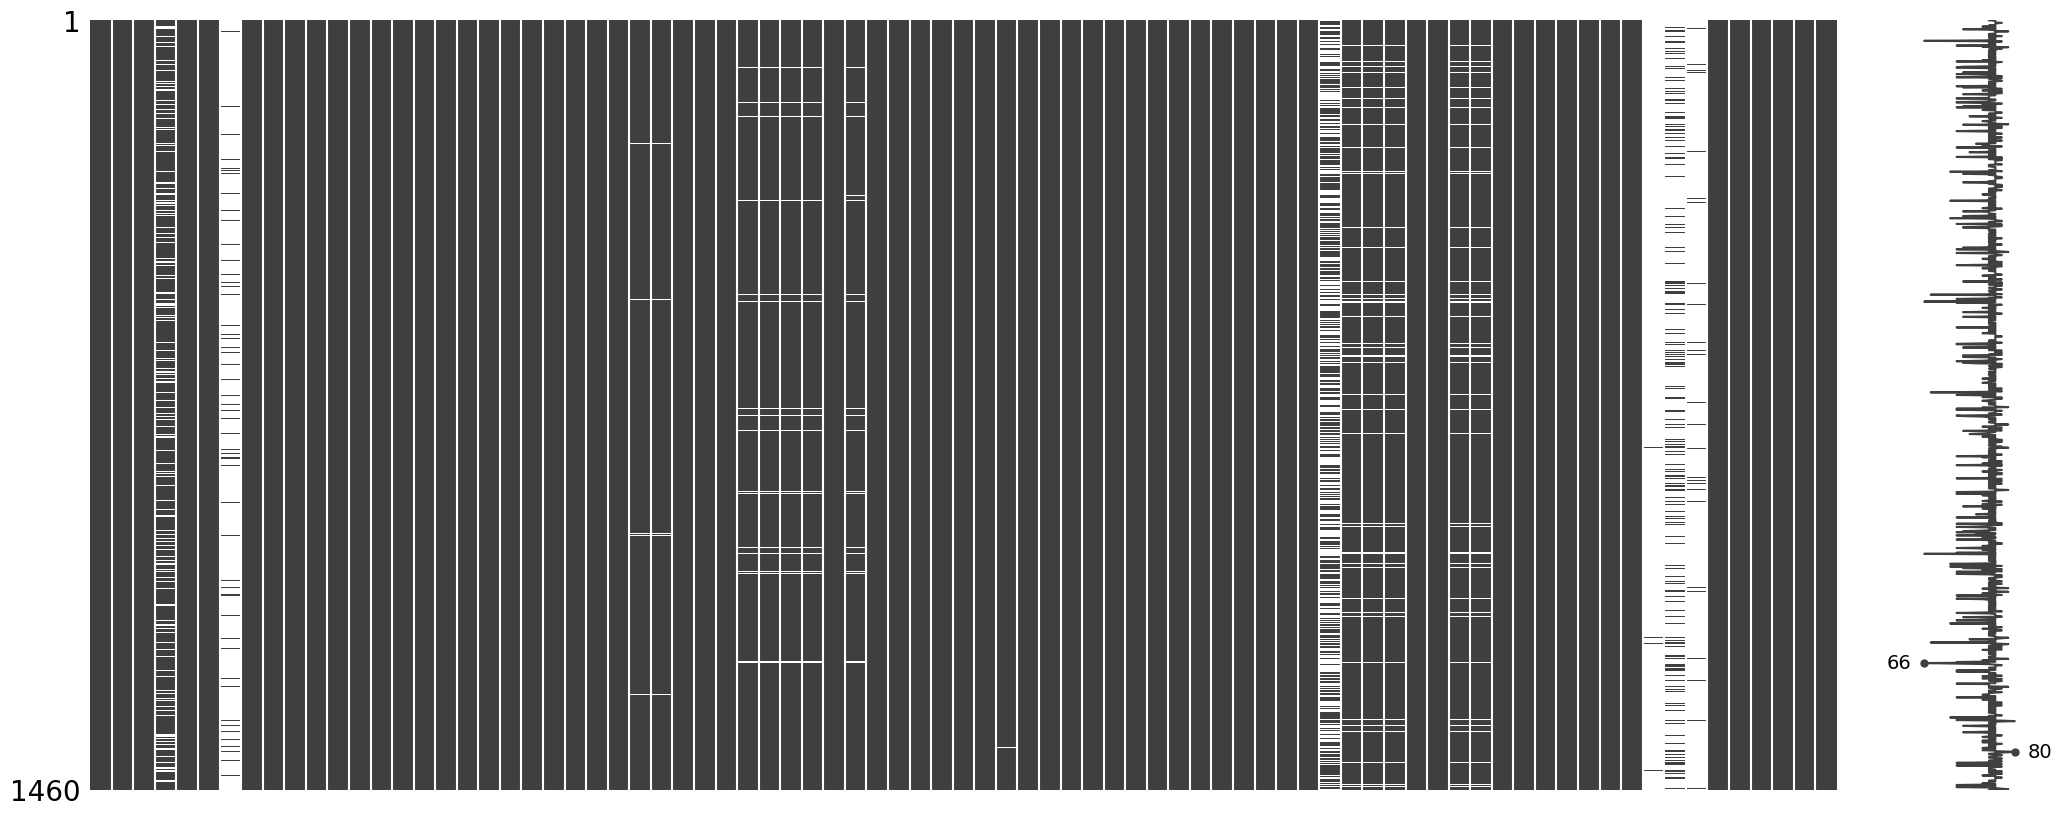

In [15]:
msno.matrix(train);

In [16]:
# train.isnull().sum().sort_values(ascending = False)[train.isnull().sum().sort_values(ascending = False) != 0]

In [17]:
def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    ## the two following line may seem complicated but its actually very simple. 
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

missing_percentage(train)

,Total,Percent
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageYrBlt,81,5.55
GarageCond,81,5.55
GarageType,81,5.55
GarageFinish,81,5.55


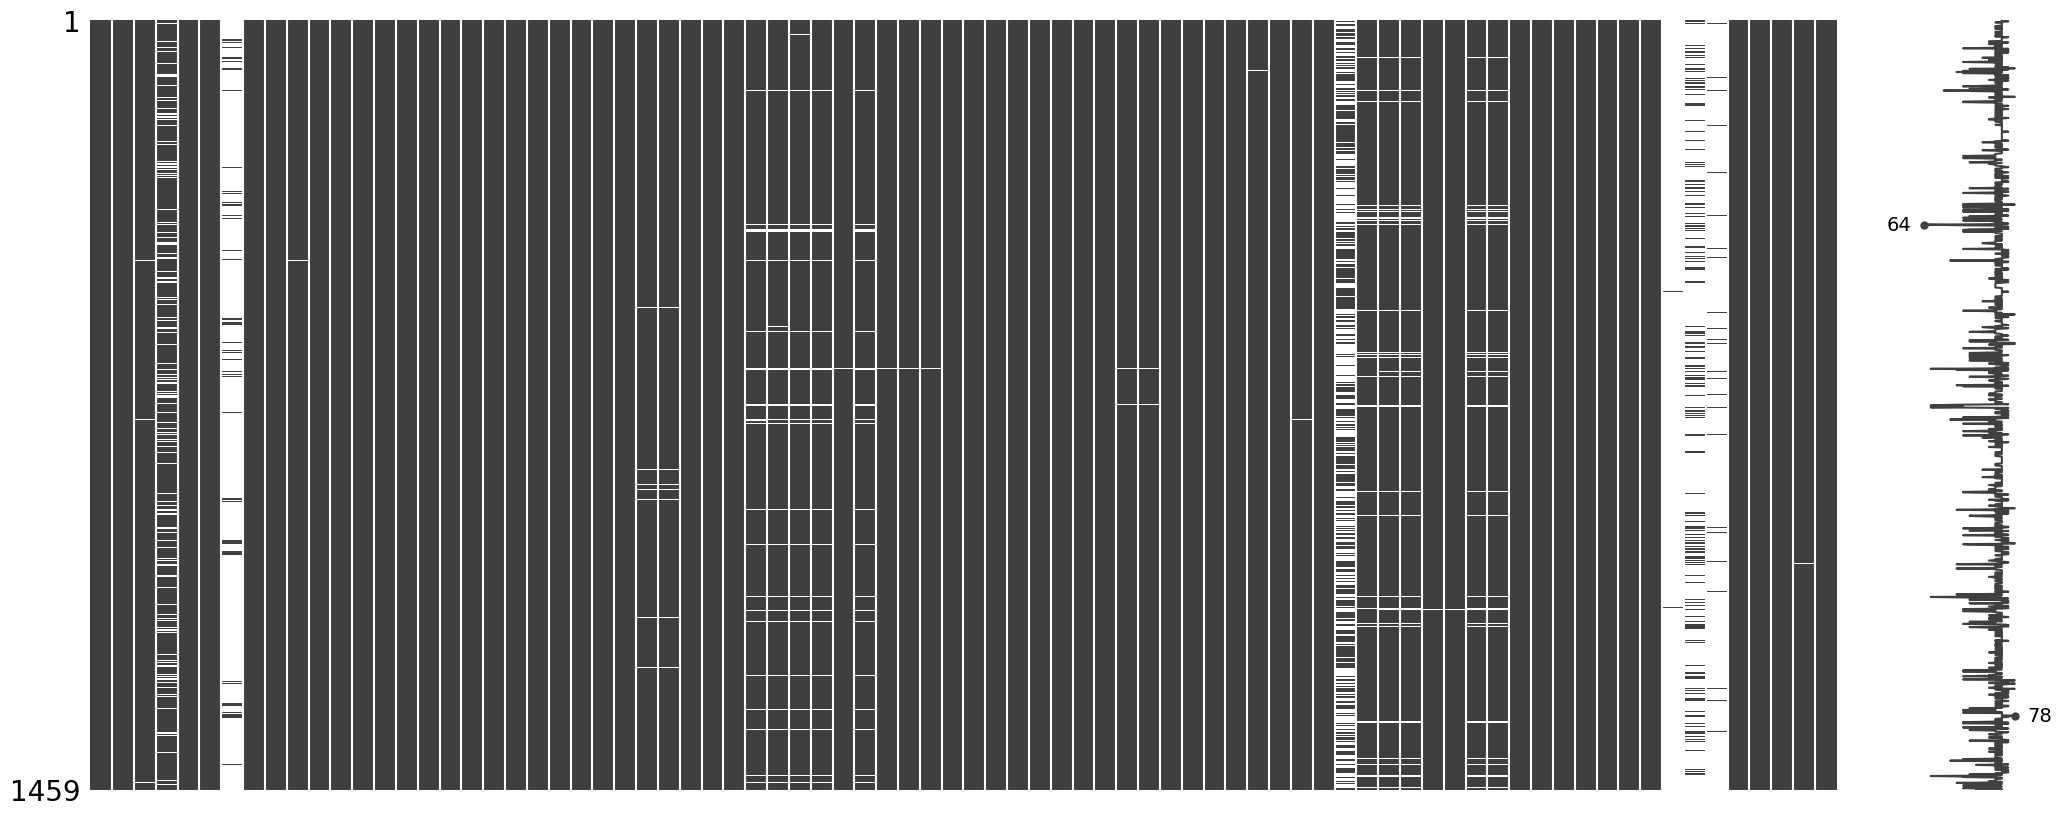

In [18]:
msno.matrix(test);

In [19]:
missing_percentage(test)

,Total,Percent
PoolQC,1456,99.79
MiscFeature,1408,96.50
Alley,1352,92.67
Fence,1169,80.12
FireplaceQu,730,50.03
LotFrontage,227,15.56
GarageYrBlt,78,5.35
GarageQual,78,5.35
GarageFinish,78,5.35
GarageCond,78,5.35


Observation
     *1.There are multiple types of features.
*2Some features have missing values.
Most of the features are object( includes string values in the variable).

I want to focus on the target variable which is SalePrice. Let's create a histogram to see if the target variable is Normally distributed. If we want to create any linear model, it is essential that the features are normally distributed. This is one of the assumptions of multiple linear regression. I will explain more on this later.

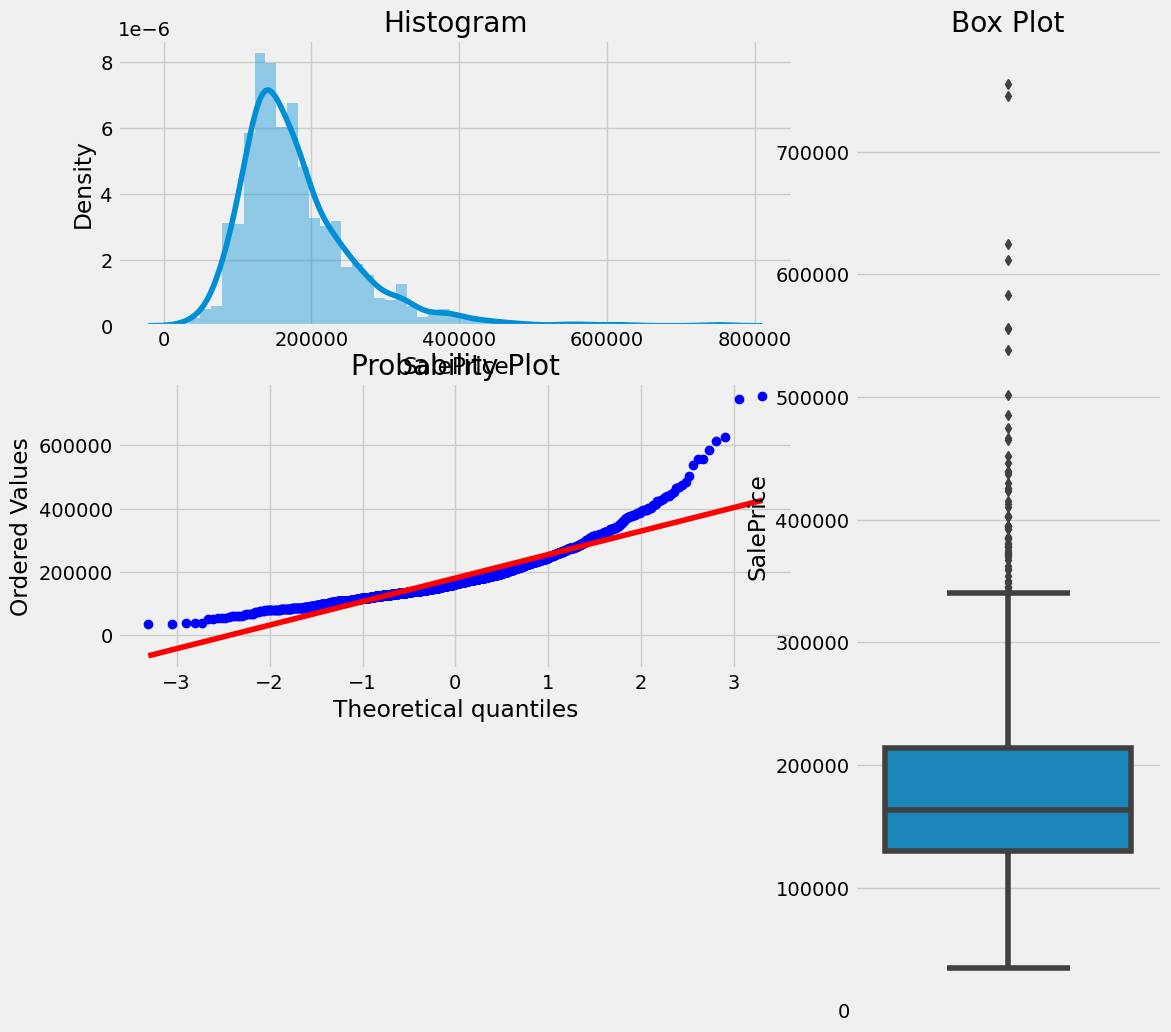

In [20]:
def plotting_3_chart(df, feature):
    ## Importing seaborn, matplotlab and scipy modules. 
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=False, figsize=(12,12))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(y=df.loc[:,feature], ax = ax3 );
    
plotting_3_chart(train, 'SalePrice')

In [21]:
#skewness and kurtosis
print("Skewness: " + str(train['SalePrice'].skew()))
print("Kurtosis: " + str(train['SalePrice'].kurt()))

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


In [22]:
## Getting the correlation of all the features with target variable. 
(train.corr()**2)["SalePrice"].sort_values(ascending = False)[1:]

OverallQual      0.625652
GrLivArea        0.502149
GarageCars       0.410124
GarageArea       0.388667
TotalBsmtSF      0.376481
1stFlrSF         0.367057
FullBath         0.314344
TotRmsAbvGrd     0.284860
YearBuilt        0.273422
YearRemodAdd     0.257151
GarageYrBlt      0.236548
MasVnrArea       0.228000
Fireplaces       0.218023
BsmtFinSF1       0.149320
LotFrontage      0.123763
WoodDeckSF       0.105244
2ndFlrSF         0.101974
OpenPorchSF      0.099765
HalfBath         0.080717
LotArea          0.069613
BsmtFullBath     0.051585
BsmtUnfSF        0.046001
BedroomAbvGr     0.028296
KitchenAbvGr     0.018471
EnclosedPorch    0.016532
ScreenPorch      0.012420
PoolArea         0.008538
MSSubClass       0.007104
OverallCond      0.006062
MoSold           0.002156
3SsnPorch        0.001988
YrSold           0.000837
LowQualFinSF     0.000656
Id               0.000480
MiscVal          0.000449
BsmtHalfBath     0.000284
BsmtFinSF2       0.000129
Name: SalePrice, dtype: float64

These are the predictor variables sorted in a descending order starting with the most correlated one OverallQual. Let's put this one in a scatter plot and see how it looks.

# SalePrice vs OverallQual

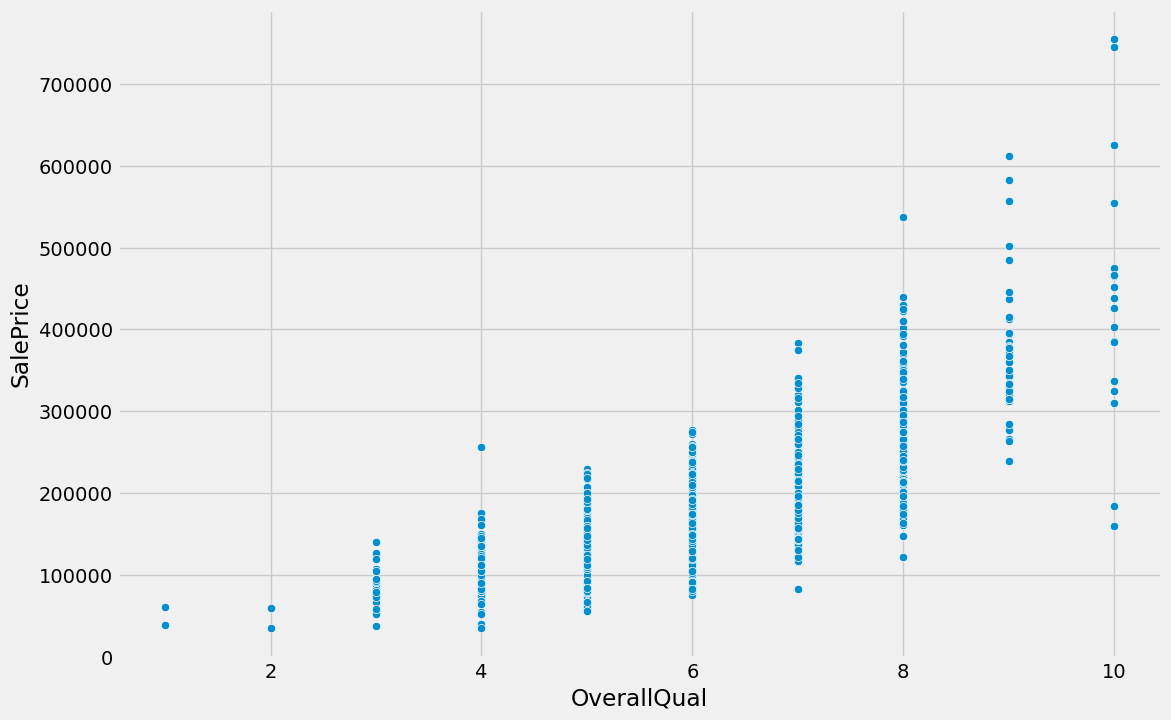

In [23]:
def customized_scatterplot(y, x):
        ## Sizing the plot. 
    style.use('fivethirtyeight')
    plt.subplots(figsize = (12,8))
    ## Plotting target variable with predictor variable(OverallQual)
    sns.scatterplot(y = y, x = x);
    
customized_scatterplot(train.SalePrice, train.OverallQual)

# SalePrice vs GrLivArea

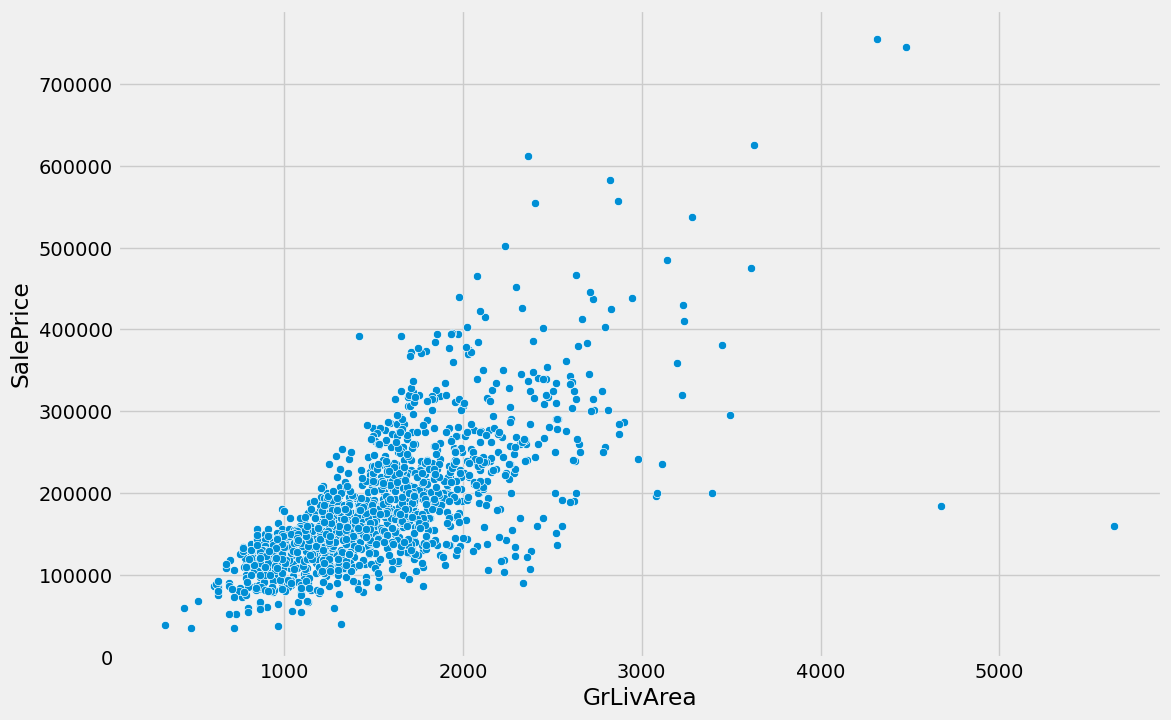

In [24]:
customized_scatterplot(train.SalePrice, train.GrLivArea)

# SalePrice vs GarageArea

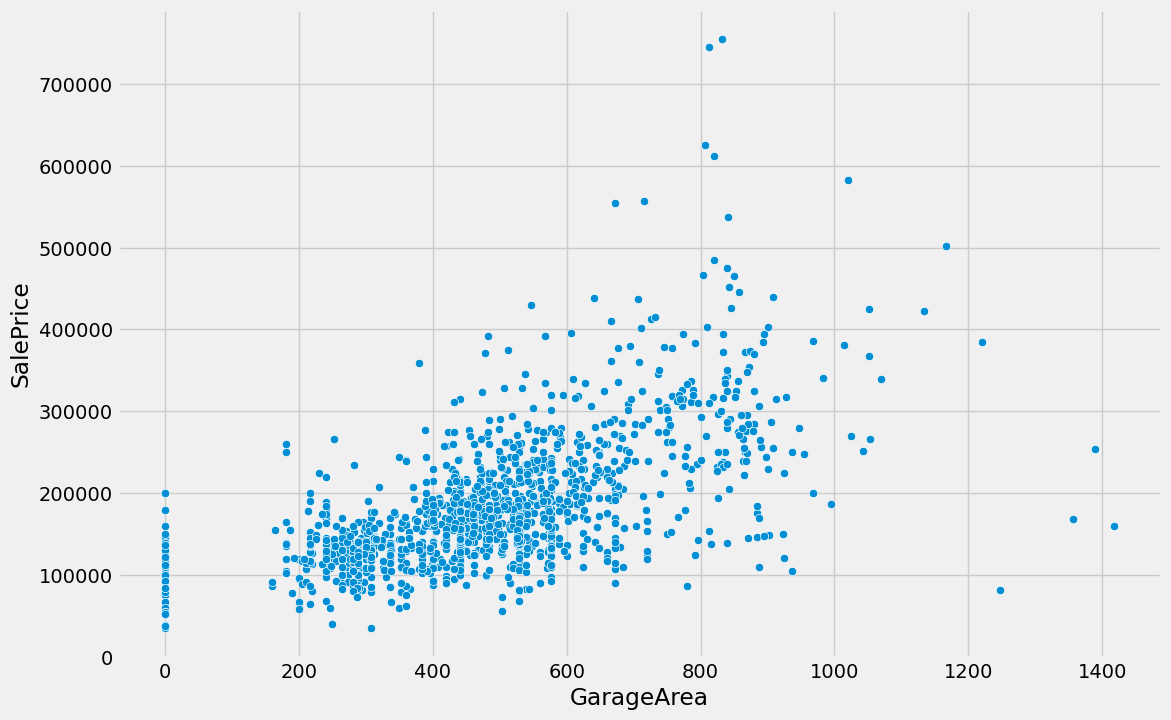

In [25]:
customized_scatterplot(train.SalePrice, train.GarageArea);

# SalePrice vs TotalBsmtSF

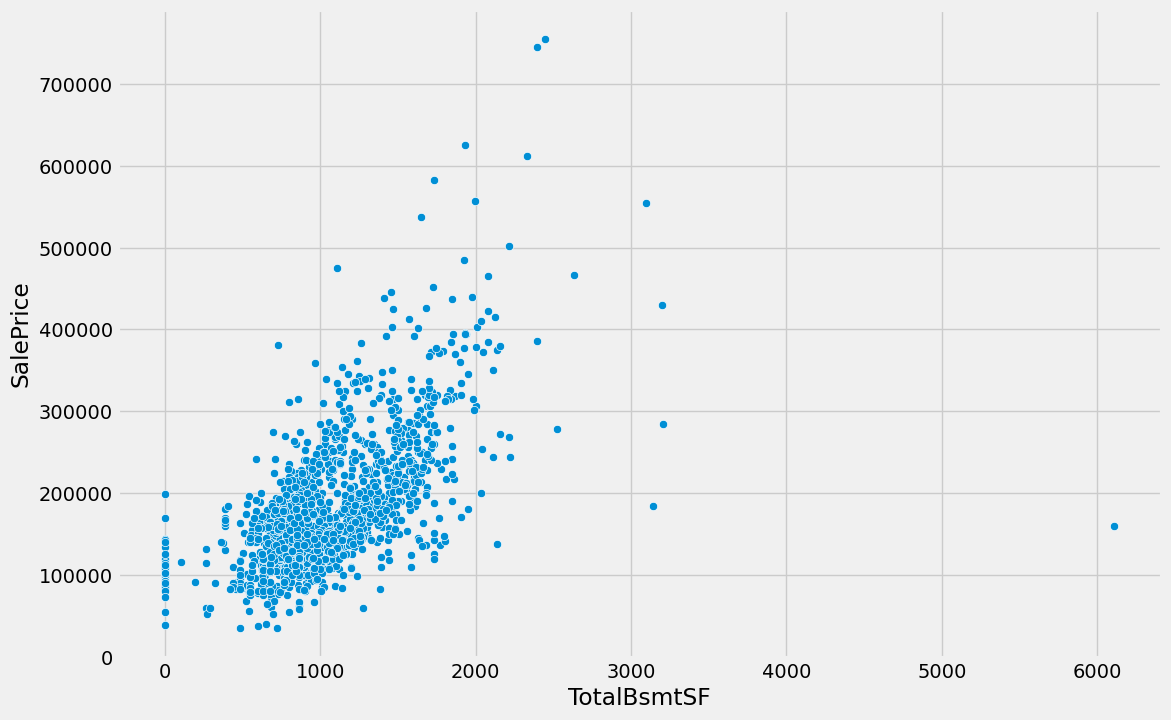

In [26]:
customized_scatterplot(train.SalePrice, train.TotalBsmtSF)

# SalePrice vs 1stFlrSF

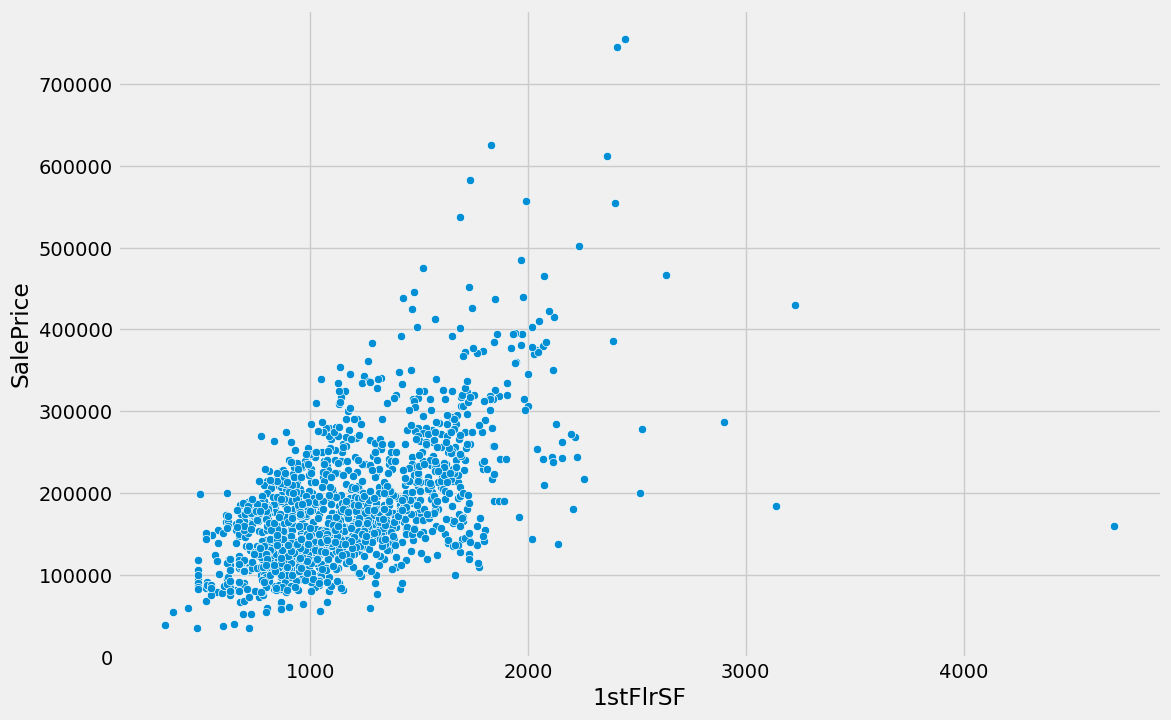

In [27]:
customized_scatterplot(train.SalePrice, train['1stFlrSF']);

# SalePrice vs MasVnrArea

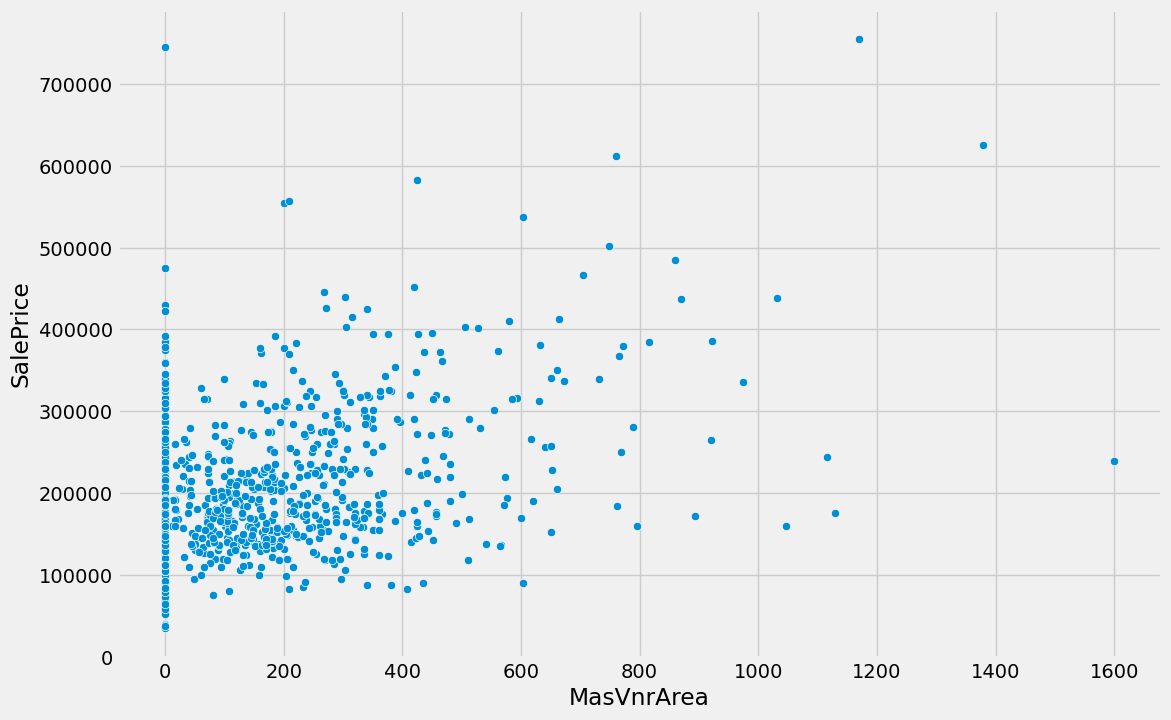

In [28]:
customized_scatterplot(train.SalePrice, train.MasVnrArea);

Observations
Our target variable shows an unequal level of variance across most predictor(independent) variables. This is called Heteroscedasticity(more explanation below) and is a red flag for the multiple linear regression model.

There are many outliers in the scatter plots above that took my attention.

The two on the top-right edge of SalePrice vs. GrLivArea seem to follow a trend, which can be explained by saying that "As the prices increased, so did the area.

However, The two on the bottom right of the same chart do not follow any trends. We will get rid of these two below.

In [29]:
## Deleting those two values with outliers. 
train = train[train.GrLivArea < 4500]
train.reset_index(drop = True, inplace = True)

## save a copy of this dataset so that any changes later on can be compared side by side.
previous_train = train.copy()

As we look through these scatter plots, I realized that it is time to explain the assumptions of Multiple Linear Regression. Before building a multiple linear regression model, we need to check that these assumptions below are valid.

Assumptions of Regression
1. Linearity ( Correct functional form )
2. *Homoscedasticity ( Constant Error Variance )( vs Heteroscedasticity ). *
3. *Independence of Errors ( vs Autocorrelation ) *
4. *Multivariate Normality ( Normality of Errors ) *
5. *No or little Multicollinearity. *

Since we fit a linear model, we assume that the relationship is linear, and the errors, or residuals, are pure random fluctuations around the true line. We expect that the variability in the response(dependent) variable doesn't increase as the value of the predictor(independent) increases, which is the assumptions of equal variance, also known as Homoscedasticity. We also assume that the observations are independent of one another(No Multicollinearity), and a correlation between sequential observations or auto-correlation is not there.

Now, these assumptions are prone to happen altogether. In other words, if we see one of these assumptions in the dataset, it's more likely that we may come across with others mentioned above. Therefore, we can find and fix various assumptions with a few unique techniques.

So, How do we check regression assumptions? We fit a regression line and look for the variability of the response data along the regression line. Let's apply this to each one of them.

Linearity(Correct functional form): Linear regression needs the relationship between each independent variable and the dependent variable to be linear. The linearity assumption can be tested with scatter plots. The following two examples depict two cases, where no or little linearity is present.

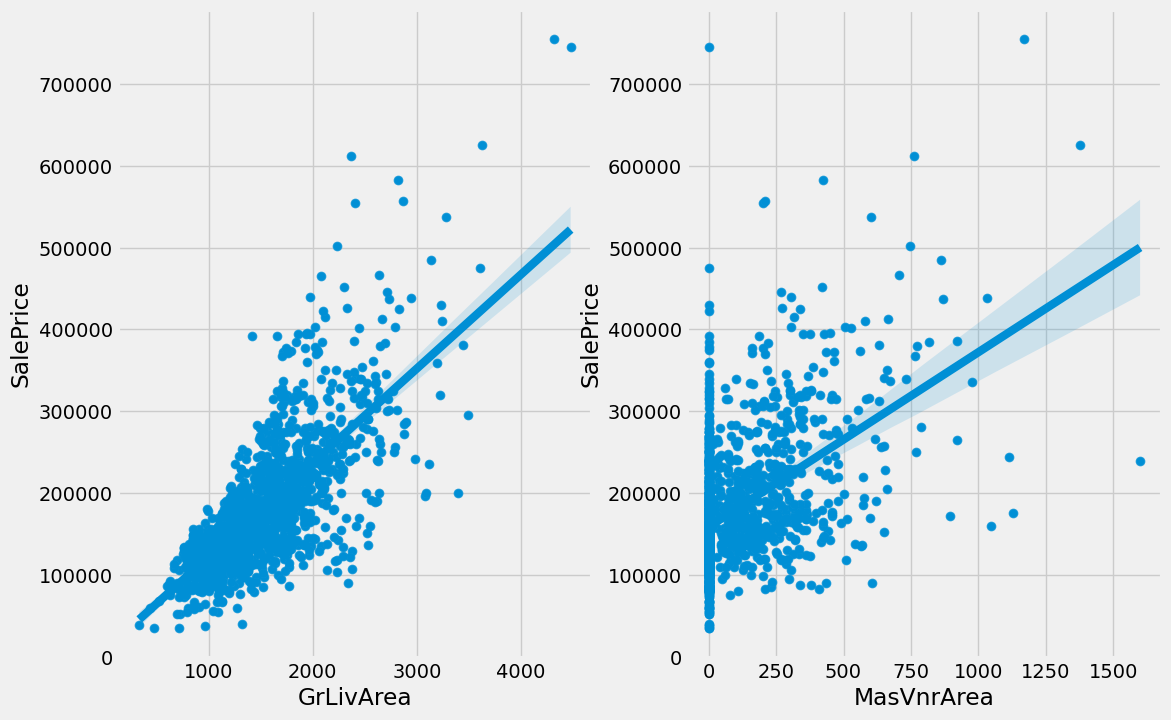

In [30]:
## Plot sizing. 
fig, (ax1, ax2) = plt.subplots(figsize = (12,8), ncols=2,sharey=False)
## Scatter plotting for SalePrice and GrLivArea. 
sns.scatterplot( x = train.GrLivArea, y = train.SalePrice,  ax=ax1)
## Putting a regression line. 
sns.regplot(x=train.GrLivArea, y=train.SalePrice, ax=ax1)

## Scatter plotting for SalePrice and MasVnrArea. 
sns.scatterplot(x = train.MasVnrArea,y = train.SalePrice, ax=ax2)
## regression line for MasVnrArea and SalePrice. 
sns.regplot(x=train.MasVnrArea, y=train.SalePrice, ax=ax2);

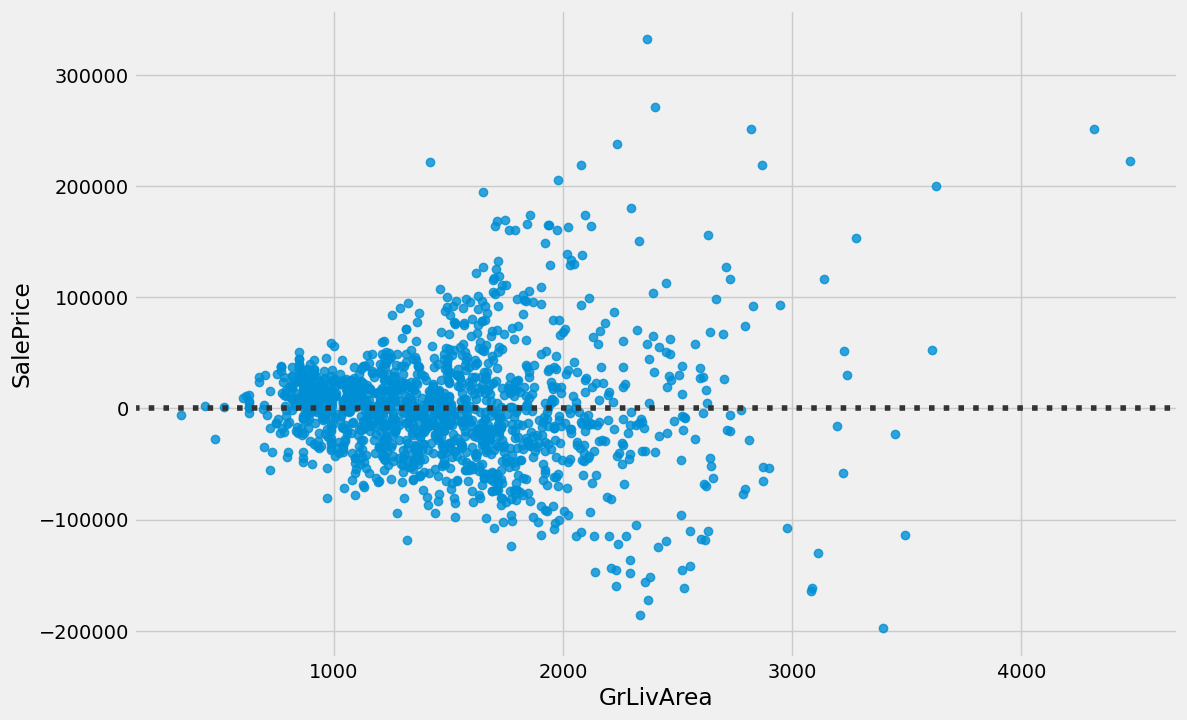

In [32]:
plt.subplots(figsize = (12,8))
sns.residplot(x = train.GrLivArea, y = train.SalePrice);

Ideally, if the assumptions are met, the residuals will be randomly scattered around the centerline of zero with no apparent pattern. The residual will look like an unstructured cloud of points centered around zero. However, our residual plot is anything but an unstructured cloud of points. Even though it seems like there is a linear relationship between the response variable and predictor variable, the residual plot looks more like a funnel. The error plot shows that as GrLivArea value increases, the variance also increases, which is the characteristics known as Heteroscedasticity. Let's break this down

Homoscedasticity ( Constant Variance ): The assumption of Homoscedasticity is crucial to linear regression models. Homoscedasticity describes a situation in which the error term or variance or the "noise" or random disturbance in the relationship between the independent variables and the dependent variable is the same across all values of the independent variable. In other words, there is a constant variance present in the response variable as the predictor variable increases. If the "noise" is not the same across the values of an independent variable like the residual plot above, we call that Heteroscedasticity. As you can tell, it is the opposite of Homoscedasticity.

Multivariate Normality ( Normality of Errors): The linear regression analysis requires the dependent variable to be multivariate normally distributed. A histogram, box plot, or a Q-Q-Plot can check if the target variable is normally distributed. The goodness of fit test, e.g., the Kolmogorov-Smirnov test can check for normality in the dependent variable. We already know that our target variable does not follow a normal distribution. Let's bring back the three charts to show our target variable.

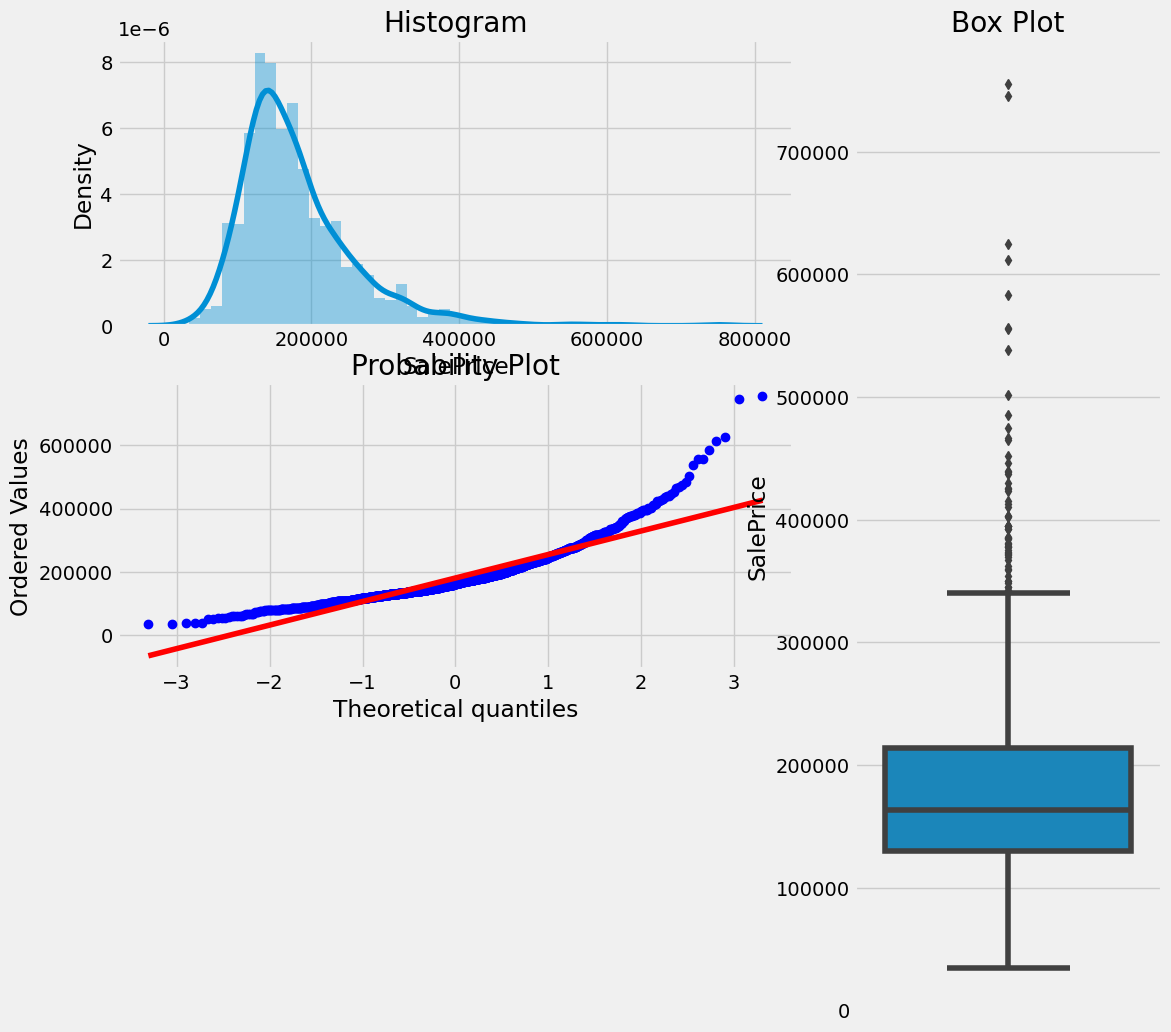

In [33]:
plotting_3_chart(train, 'SalePrice')

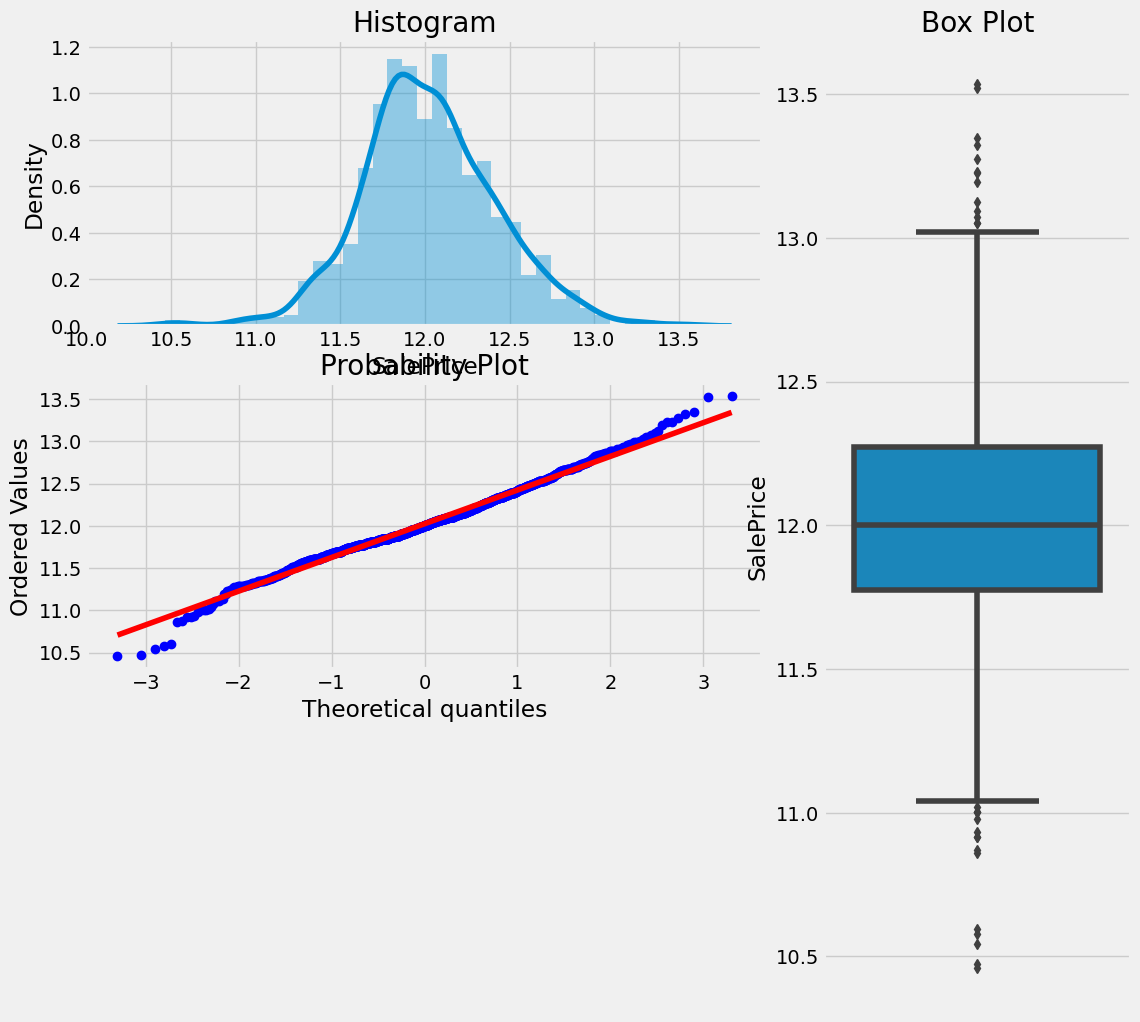

In [34]:
## trainsforming target variable using numpy.log1p, 
train["SalePrice"] = np.log1p(train["SalePrice"])

## Plotting the newly transformed response variable
plotting_3_chart(train, 'SalePrice')

As you can see, the log transformation removes the normality of errors, which solves most of the other errors we talked about above. Let's make a comparison of the pre-transformed and post-transformed state of residual plots.

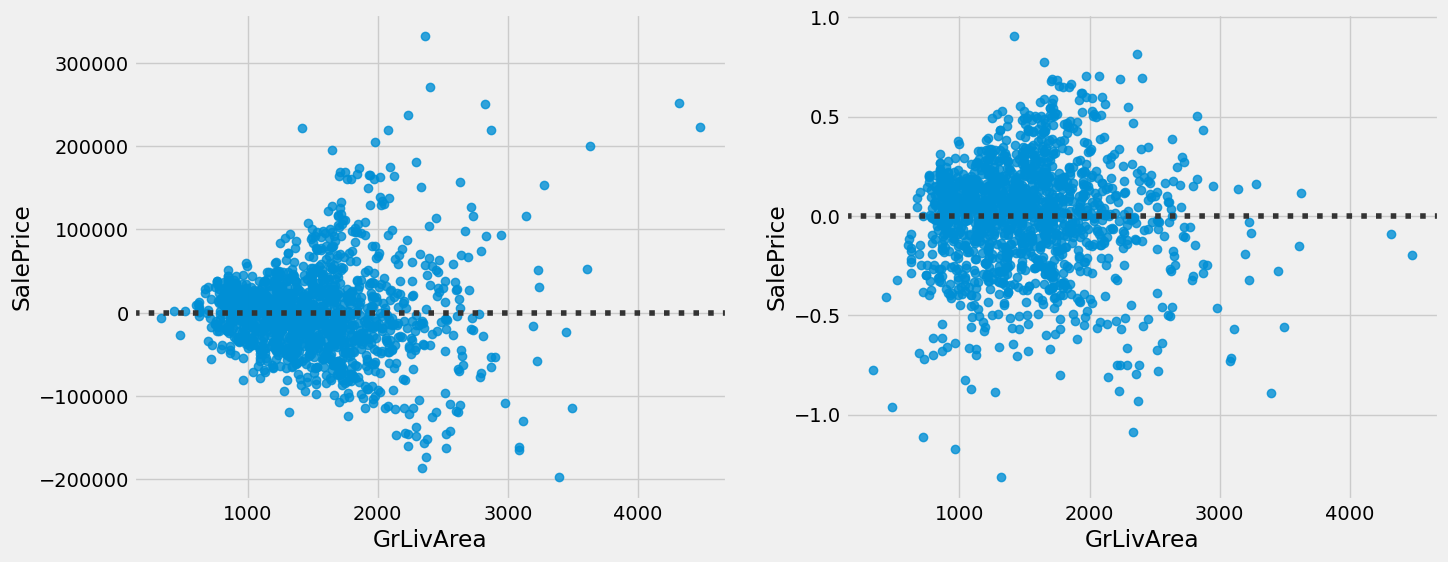

In [35]:
## Customizing grid for two plots. 
fig, (ax1, ax2) = plt.subplots(figsize = (15,6), 
                               ncols=2, 
                               sharey = False, 
                               sharex=False
                              )
## doing the first scatter plot. 
sns.residplot(x = previous_train.GrLivArea, y = previous_train.SalePrice, ax = ax1)
## doing the scatter plot for GrLivArea and SalePrice. 
sns.residplot(x = train.GrLivArea, y = train.SalePrice, ax = ax2);

Here, we see that the pre-transformed chart on the left has heteroscedasticity, and the post-transformed chart on the right has Homoscedasticity(almost an equal amount of variance across the zero lines). It looks like a blob of data points and doesn't seem to give away any relationships. That's the sort of relationship we would like to see to avoid some of these assumptions.

No or Little multicollinearity: Multicollinearity is when there is a strong correlation between independent variables. Linear regression or multilinear regression requires independent variables to have little or no similar features. Multicollinearity can lead to a variety of problems, including:

    1. The effect of predictor variables estimated by our regression will depend on what other variables are included in our model.
    2. Predictors can have wildly different results depending on the observations in our sample, and small changes in samples can result in very different estimated effects.
    3. With very high multicollinearity, the inverse matrix, the computer calculates may not be accurate.
    4. We can no longer interpret a coefficient on a variable as the effect on the target of a one-unit increase in that variable holding the other variables constant. The reason behind that is, when predictors are strongly correlated, there is not a scenario in which one variable can change without a conditional change in another variable.

Heatmap is an excellent way to identify whether there is multicollinearity or not. The best way to solve multicollinearity is to use regularization methods like Ridge or Lasso.

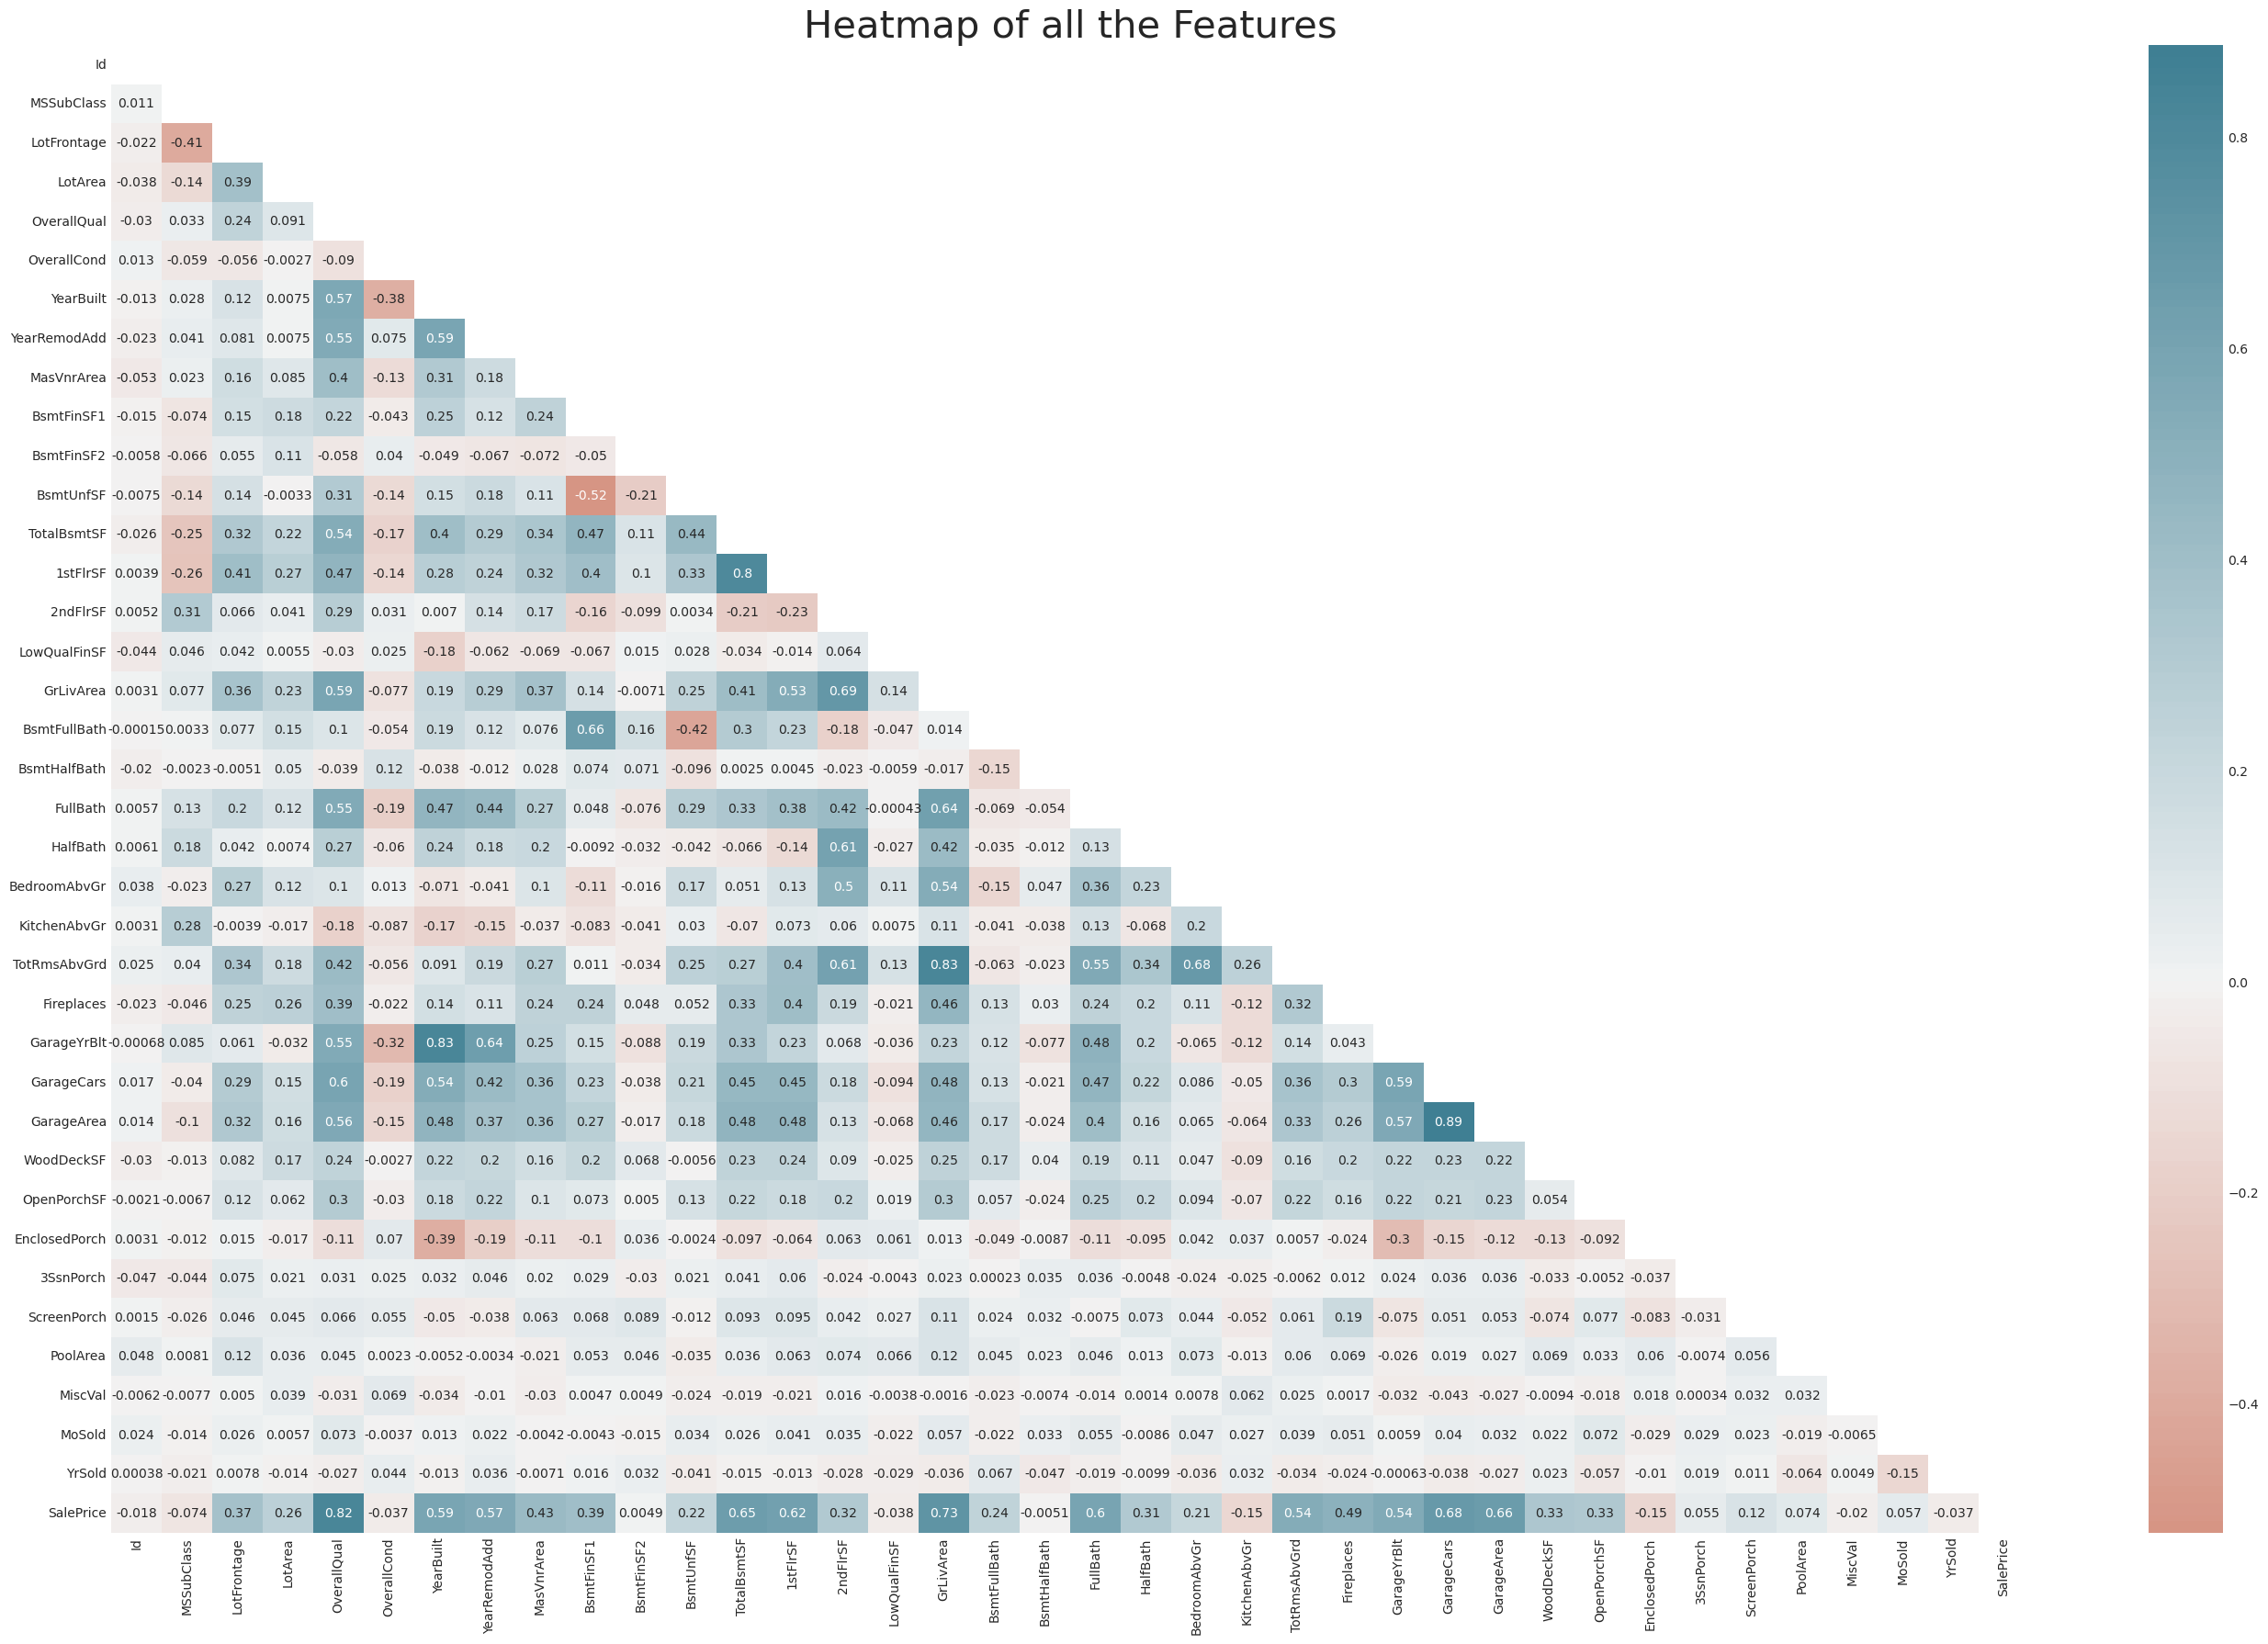

In [36]:
## Plot fig sizing. 
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (30,20))
## Plotting heatmap. 

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(train.corr(), 
            cmap=sns.diverging_palette(20, 220, n=200), 
            mask = mask, 
            annot=True, 
            center = 0, 
           );
## Give title. 
plt.title("Heatmap of all the Features", fontsize = 30);

Observation.

As we can see, the multicollinearity still exists in various features. However, we will keep them for now for the sake of learning and let the models(e.x. Regularization models such as Lasso, Ridge) do the clean up later on. Let's go through some of the correlations that still exists.

    1. There is 0.83 or 83% correlation between GarageYrBlt and YearBuilt.
    2. 83% correlation between TotRmsAbvGrd ** and **GrLivArea.
    3. 89% correlation between GarageCars and GarageArea.
    4. Similarly many other features such asBsmtUnfSF, FullBath have good correlation with other independent feature.

If I were using only multiple linear regression, I would be deleting these features from the dataset to fit better multiple linear regression algorithms. However, we will be using many algorithms as scikit learn modules makes it easy to implement them and get the best possible outcome. Therefore, we will keep all the features for now.

# Feature Engineering

In [37]:
## Dropping the "Id" from train and test set. 
# train.drop(columns=['Id'],axis=1, inplace=True)

train.drop(columns=['Id'],axis=1, inplace=True)
test.drop(columns=['Id'],axis=1, inplace=True)

## Saving the target values in "y_train". 
y = train['SalePrice'].reset_index(drop=True)



# getting a copy of train
previous_train = train.copy()

In [38]:
## Combining train and test datasets together so that we can do all the work at once. 
all_data = pd.concat((train, test)).reset_index(drop = True)
## Dropping the target variable. 
all_data.drop(['SalePrice'], axis = 1, inplace = True)

# Dealing with Missing Values

In [39]:
missing_percentage(all_data)

,Total,Percent
PoolQC,2908,99.69
MiscFeature,2812,96.40
Alley,2719,93.21
Fence,2346,80.43
FireplaceQu,1420,48.68
LotFrontage,486,16.66
GarageYrBlt,159,5.45
GarageFinish,159,5.45
GarageQual,159,5.45
GarageCond,159,5.45


Imputing missing values

In [40]:
## Some missing values are intentionally left blank, for example: In the Alley feature 
## there are blank values meaning that there are no alley's in that specific house. 
missing_val_col = ["Alley", 
                   "PoolQC", 
                   "MiscFeature",
                   "Fence",
                   "FireplaceQu",
                   "GarageType",
                   "GarageFinish",
                   "GarageQual",
                   "GarageCond",
                   'BsmtQual',
                   'BsmtCond',
                   'BsmtExposure',
                   'BsmtFinType1',
                   'BsmtFinType2',
                   'MasVnrType']

for i in missing_val_col:
    all_data[i] = all_data[i].fillna('None')

In [41]:
## In the following features the null values are there for a purpose, so we replace them with "0"
missing_val_col2 = ['BsmtFinSF1',
                    'BsmtFinSF2',
                    'BsmtUnfSF',
                    'TotalBsmtSF',
                    'BsmtFullBath', 
                    'BsmtHalfBath', 
                    'GarageYrBlt',
                    'GarageArea',
                    'GarageCars',
                    'MasVnrArea']

for i in missing_val_col2:
    all_data[i] = all_data[i].fillna(0)
    
## Replaced all missing values in LotFrontage by imputing the median value of each neighborhood. 
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform( lambda x: x.fillna(x.mean()))

In [42]:
## the "OverallCond" and "OverallQual" of the house. 
# all_data['OverallCond'] = all_data['OverallCond'].astype(str) 
# all_data['OverallQual'] = all_data['OverallQual'].astype(str)

## Zoning class are given in numerical; therefore converted to categorical variables. 
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['MSZoning'] = all_data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

## Important years and months that should be categorical variables not numerical. 
# all_data['YearBuilt'] = all_data['YearBuilt'].astype(str)
# all_data['YearRemodAdd'] = all_data['YearRemodAdd'].astype(str)
# all_data['GarageYrBlt'] = all_data['GarageYrBlt'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str) 

In [43]:
all_data['Functional'] = all_data['Functional'].fillna('Typ') 
all_data['Utilities'] = all_data['Utilities'].fillna('AllPub') 
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0]) 
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna("TA") 
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna("SBrkr") 


In [44]:
missing_percentage(all_data)

,Total,Percent


# Fixing Skewness

In [45]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)

skewed_feats

MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
MasVnrArea        2.621719
OpenPorchSF       2.529358
WoodDeckSF        1.844792
1stFlrSF          1.257286
GrLivArea         1.068750
LotFrontage       1.058803
BsmtFinSF1        0.980645
BsmtUnfSF         0.919688
2ndFlrSF          0.861556
TotRmsAbvGrd      0.749232
Fireplaces        0.725278
HalfBath          0.696666
TotalBsmtSF       0.671751
BsmtFullBath      0.622415
OverallCond       0.569314
BedroomAbvGr      0.326568
GarageArea        0.216857
OverallQual       0.189591
FullBath          0.165514
GarageCars       -0.219297
YearRemodAdd     -0.450134
YearBuilt        -0.599194
GarageYrBlt      -3.904632
dtype: float64

In [46]:
## Fixing Skewed features using boxcox transformation. 


def fixing_skewness(df):
    """
    This function takes in a dataframe and return fixed skewed dataframe
    """
    ## Import necessary modules 
    from scipy.stats import skew
    from scipy.special import boxcox1p
    from scipy.stats import boxcox_normmax
    
    ## Getting all the data that are not of "object" type. 
    numeric_feats = df.dtypes[df.dtypes != "object"].index

    # Check the skew of all numerical features
    skewed_feats = df[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skewed_feats[abs(skewed_feats) > 0.5]
    skewed_features = high_skew.index

    for feat in skewed_features:
        df[feat] = boxcox1p(df[feat], boxcox_normmax(df[feat] + 1))

fixing_skewness(all_data)

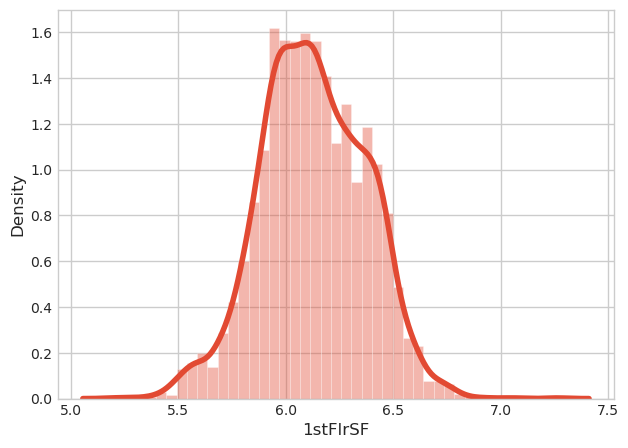

In [47]:
sns.distplot(all_data['1stFlrSF']);

# Creating new features

In [48]:
# feture engineering a new feature "TotalFS"
all_data['TotalSF'] = (all_data['TotalBsmtSF'] 
                       + all_data['1stFlrSF'] 
                       + all_data['2ndFlrSF'])

all_data['YrBltAndRemod'] = all_data['YearBuilt'] + all_data['YearRemodAdd']

all_data['Total_sqr_footage'] = (all_data['BsmtFinSF1'] 
                                 + all_data['BsmtFinSF2'] 
                                 + all_data['1stFlrSF'] 
                                 + all_data['2ndFlrSF']
                                )
                                 

all_data['Total_Bathrooms'] = (all_data['FullBath'] 
                               + (0.5 * all_data['HalfBath']) 
                               + all_data['BsmtFullBath'] 
                               + (0.5 * all_data['BsmtHalfBath'])
                              )
                               

all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] 
                              + all_data['3SsnPorch'] 
                              + all_data['EnclosedPorch'] 
                              + all_data['ScreenPorch'] 
                              + all_data['WoodDeckSF']
                             )
                              
                              


In [49]:
all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [50]:
all_data.shape

(2917, 89)

# Deleting Features

In [51]:
all_data = all_data.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

# Creating Dummy Variable

In [52]:
## Creating dummy variable 
final_features = pd.get_dummies(all_data).reset_index(drop=True)
final_features.shape

(2917, 333)

In [53]:
X = final_features.iloc[:len(y), :]

X_sub = final_features.iloc[len(y):, :]

In [54]:
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

In [55]:
counts = X.BsmtUnfSF.value_counts()

In [56]:
counts.iloc[0]

117

In [57]:
for i in X.columns:
    counts = X[i].value_counts()
    print (counts)

17.840337    142
19.692956     70
21.443061     69
15.860626     56
20.579605     52
            ... 
31.864058      1
30.655039      1
26.530594      1
12.088317      1
15.025509      1
Name: LotFrontage, Length: 132, dtype: int64
13.480169    25
14.117918    24
13.084300    17
13.973432    14
13.819883    14
             ..
10.307049     1
14.092057     1
15.228341     1
13.005459     1
14.145130     1
Name: LotArea, Length: 1068, dtype: int64
5     396
6     374
7     318
8     167
4     115
9      43
3      19
10     16
2       3
1       2
Name: OverallQual, dtype: int64
3.991517    816
4.679501    252
5.348041    205
6.000033     72
3.280100     56
2.539440     25
6.637669     22
1.760360      4
0.926401      1
Name: OverallCond, dtype: int64
2.803702e+51    66
2.781514e+51    64
2.759490e+51    54
2.826056e+51    48
2.737630e+51    45
                ..
9.558503e+50     1
1.294180e+51     1
1.360466e+51     1
9.317708e+50     1
1.230930e+51     1
Name: YearBuilt, Length: 112, dty

0    1451
1       2
Name: MiscFeature_Gar2, dtype: int64
1    1399
0      54
Name: MiscFeature_None, dtype: int64
0    1451
1       2
Name: MiscFeature_Othr, dtype: int64
0    1404
1      49
Name: MiscFeature_Shed, dtype: int64
0    1452
1       1
Name: MiscFeature_TenC, dtype: int64
0    1396
1      57
Name: MoSold_1, dtype: int64
0    1366
1      87
Name: MoSold_10, dtype: int64
0    1374
1      79
Name: MoSold_11, dtype: int64
0    1395
1      58
Name: MoSold_12, dtype: int64
0    1402
1      51
Name: MoSold_2, dtype: int64
0    1347
1     106
Name: MoSold_3, dtype: int64
0    1313
1     140
Name: MoSold_4, dtype: int64
0    1249
1     204
Name: MoSold_5, dtype: int64
0    1200
1     253
Name: MoSold_6, dtype: int64
0    1220
1     233
Name: MoSold_7, dtype: int64
0    1331
1     122
Name: MoSold_8, dtype: int64
0    1390
1      63
Name: MoSold_9, dtype: int64
0    1139
1     314
Name: YrSold_2006, dtype: int64
0    1126
1     327
Name: YrSold_2007, dtype: int64
0    1151
1     302


In [58]:
def overfit_reducer(df):
    """
    This function takes in a dataframe and returns a list of features that are overfitted.
    """
    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.94:
            overfit.append(i)
    overfit = list(overfit)
    return overfit


overfitted_features = overfit_reducer(X)

X = X.drop(overfitted_features, axis=1)
X_sub = X_sub.drop(overfitted_features, axis=1)

In [59]:
X.shape,y.shape, X_sub.shape

((1453, 332), (1453,), (1459, 332))

# Fitting Model

In [60]:
## Train test s
from sklearn.model_selection import train_test_split
## Train test split follows this distinguished code pattern and helps creating train and test set to build machine learning. 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .33, random_state = 0)

In [61]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((973, 332), (973,), (480, 332), (480,))

# Modeling the data

Linear Regression

We will start with one of the most basic but useful machine learning model, **Linear Regression**. However, do not let the simplicity of this model fool you, as Linear Regression is the base some of the most complex models out there. For the sake of understanding this model, we will use only two features, **SalePrice** and **GrLivArea**. Let's take a sample of the data and graph it.

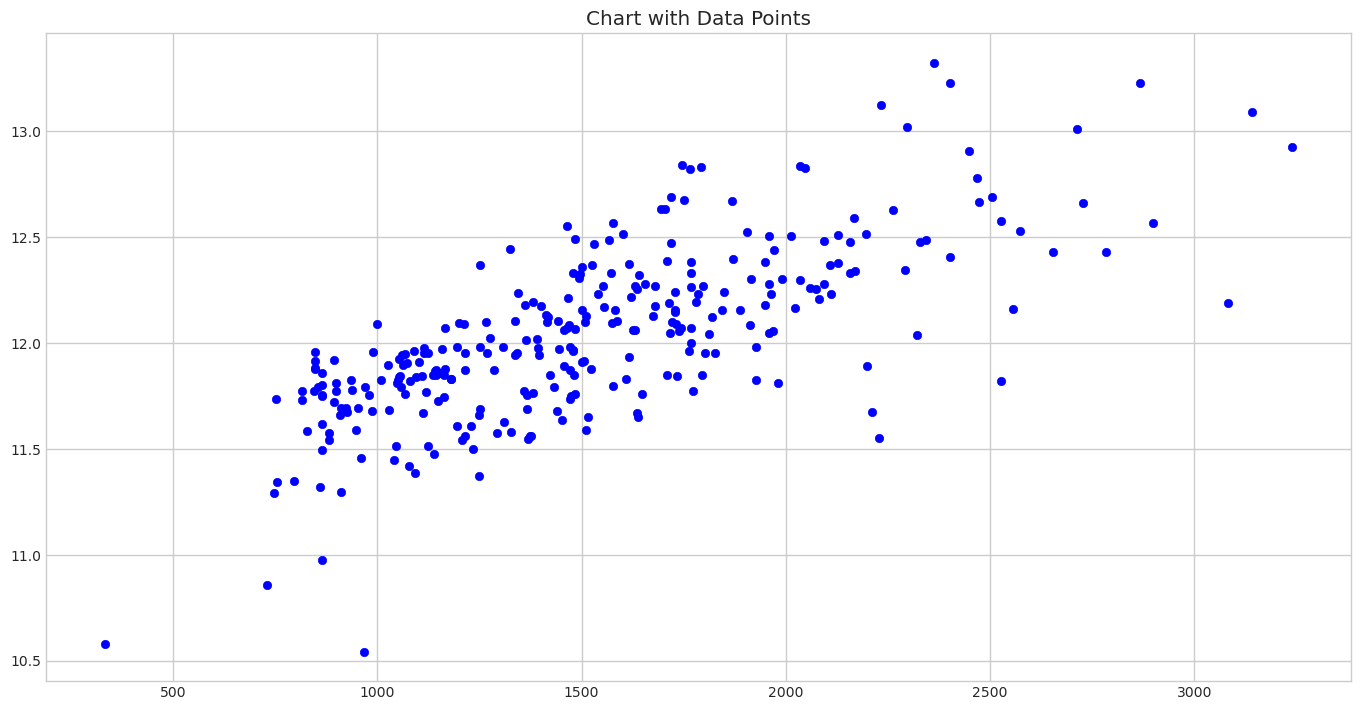

In [62]:
sample_train = previous_train.sample(300)
import seaborn as sns
plt.subplots(figsize = (15,8))
ax = plt.gca()
ax.scatter(sample_train.GrLivArea.values, sample_train.SalePrice.values, color ='b');
plt.title("Chart with Data Points");
#ax = sns.regplot(sample_train.GrLivArea.values, sample_train.SalePrice.values)
#ax.plot((sample_train.GrLivArea.values.min(),sample_train.GrLivArea.values.max()), (sample_train.SalePrice.values.mean(),sample_train.SalePrice.values.mean()), color = 'r');

As we discussed before, there is a linear relationship between SalePrice and GrLivArea. We want to know/estimate/predict the sale price of a house based on the given area, How do we do that? One naive way is to find the average of all the house prices. Let's find a line with the average of all houses and place it in the scatter plot. Simple enough.

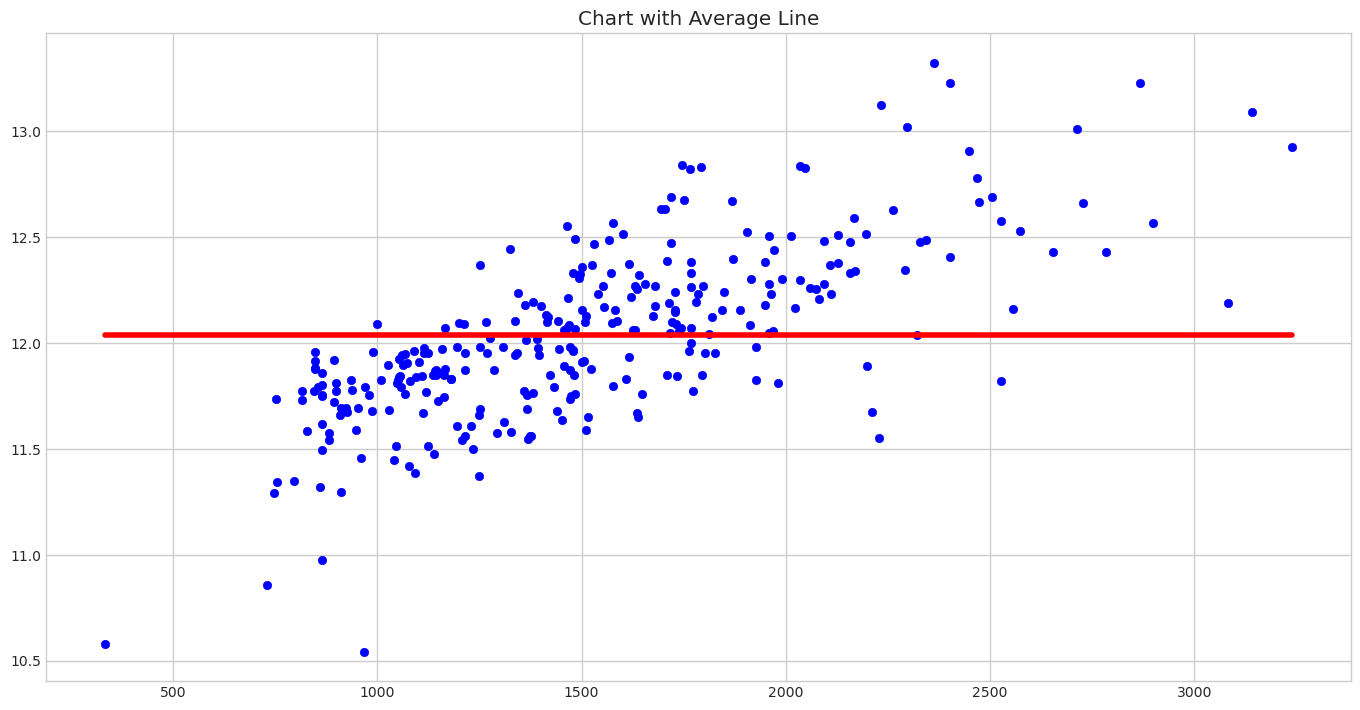

In [63]:
plt.subplots(figsize = (15,8))
ax = plt.gca()
ax.scatter(sample_train.GrLivArea.values, sample_train.SalePrice.values, color ='b');
#ax = sns.regplot(sample_train.GrLivArea.values, sample_train.SalePrice.values)
ax.plot((sample_train.GrLivArea.values.min(),sample_train.GrLivArea.values.max()), (sample_train.SalePrice.values.mean(),sample_train.SalePrice.values.mean()), color = 'r');
plt.title("Chart with Average Line");

You can tell this is not the most efficient way to estimate the price of houses. The average line clearly does not represent all the datapoint and fails to grasp the linear relationship between GrLivArea & SalePrice. Let use one of the evaluation regression metrics and find out the Mean Squared Error(more on this later) of this line.

In [64]:
## Calculating Mean Squared Error(MSE)
sample_train['mean_sale_price'] = sample_train.SalePrice.mean()
sample_train['mse'] = np.square(sample_train.mean_sale_price - sample_train.SalePrice)
sample_train.mse.mean()
## getting mse
print("Mean Squared Error(MSE) for average line is : {}".format(sample_train.mse.mean()))

Mean Squared Error(MSE) for average line is : 0.16239707216401095


We will explain more on MSE later. For now, let's just say, the closer the value of MSE is to "0", the better. Of course, it makes sense since we are talking about an error(mean squared error). We want to minimize this error. How can we do that?

Introducing Linear Regression, one of the most basic and straightforward models. Many of us may have learned to show the relationship between two variable using something called "y equals mX plus b." Let's refresh our memory and call upon on that equation.

𝑦=𝑚𝑋+𝑏
 
Here,

m = slope of the regression line. It represents the relationship between X and y. In another word, it gives weight as to for each x(horizontal space) how much y(vertical space) we have to cover. In machine learning, we call it coefficient.
b = y-intercept.
x and y are the data points located in x_axis and y_axis respectively.

If you would like to know more about this equation, Please check out this video.

This slope equation gives us an exact linear relationship between X and y. This relationship is "exact" because we are given X and y beforehand and based on the value of X and y, we come up with the slope and y-intercept, which in turns determine the relationship between X and y. However, in real life, data is not that simple. Often the relationship is unknown to us, and even if we know the relationship, it may not always be exact. To fit an exact slope equation in an inexact relationship of data we introduce the term error. Let's see how mathematicians express this error with the slope equation.

𝑦=𝛽0+𝛽1𝑥+𝜖
And, this is the equation for a simple linear regression. Here,

y = Dependent variable. This is what we are trying to estimate/solve/understand.
𝛽0  = the y-intercept, it is a constant and it represents the value of y when x is 0.
𝛽1  = Slope, Weight, Coefficient of x. This metrics is the relationship between y and x. In simple terms, it shows 1 unit increase in y changes when 1 unit increases in x.
𝑥1  = Independent variable ( simple linear regression ) /variables.
𝜖  = error or residual.
residual𝑖=𝑦𝑖−𝑦̂ 𝑖
 
This error is the only part that's different/addition from the slope equation. This error exists because in real life we will never have a dataset where the regression line crosses exactly every single data point. There will be at least a good amount of points where the regression line will not be able to go through for the sake of model specifications and ** bias-variance tradeoff **(more on this later). This error term accounts for the difference of those points. So, simply speaking, an error is the difference between an original value(  𝑦𝑖  ) and a predicted value(  𝑦̂ 𝑖  ).

We use this function to predict the values of one dependent(target) variable based on one independent(predictor) variable. Therefore this regression is called Simple linear regression(SLR). If we were to write the equation regarding the sample example above it would simply look like the following equation,

𝑆𝑎𝑙𝑒𝑃𝑟𝑖𝑐𝑒=𝛽0+𝛽1(𝐴𝑟𝑒𝑎)+𝜖
This equation gives us a line that fits the data and often performs better than the average line above. But,

How do we know that Linear regression line is actually performing better than the average line?
What metrics can we use to answer that?
How do we know if this line is even the best line(best-fit line) for the dataset?
If we want to get even more clear on this we may start with answering, How do we find the  𝛽0 (intercept) and  𝛽1 (coefficient) of the equation?
Finding  𝛽0 (intercept) and  𝛽1 (coefficient):

We can use the following equation to find the  𝛽0 (intercept) and  𝛽1 (coefficient)

𝛽̂ 1=𝑟𝑥𝑦𝑠𝑦𝑠𝑥
 
𝛽̂ 0=𝑦¯−𝛽̂ 1𝑥¯
 
Here...

𝑦¯  : the sample mean of observed values  𝑌 
𝑥¯  : the sample mean of observed values  𝑋 
𝑠𝑦  : the sample standard deviation of observed values  𝑌 
𝑠𝑥  : the sample standard deviation of observed values  𝑋 
There are two types of STD's. one is for sample population and one is for Total population. Check out this article for more.

𝑟𝑥𝑦  : the sample Pearson correlation coefficient between observed  𝑋  and  𝑌 
I hope most of us know how to calculate all these components from the two equations above by hand. I am going to only mention the equation of the pearson correlation(r_xy) here as it may be unknown to some of the readers.

𝑟𝑥𝑦=∑(𝑥𝑖−𝑥¯)(𝑦𝑖−𝑦¯)∑(𝑥𝑖−𝑥¯)2∑(𝑦𝑖−𝑦¯)2⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯√
 
Let's get on with calculating the rest by coding.

In [65]:
## Calculating the beta coefficients by hand. 
## mean of y. 
y_bar = sample_train.SalePrice.mean()
## mean of x. 
x_bar = sample_train.GrLivArea.mean()
## Std of y
std_y = sample_train.SalePrice.std()
## std of x
std_x = sample_train.GrLivArea.std()
## correlation of x and y
r_xy = sample_train.corr().loc['GrLivArea','SalePrice']
## finding beta_1
beta_1 = r_xy*(std_y/std_x)
## finding beta_0
beta_0 = y_bar - beta_1*x_bar

In [66]:
## getting y_hat, which is the predicted y values. 
sample_train['Linear_Yhat'] = beta_0 + beta_1*sample_train['GrLivArea']

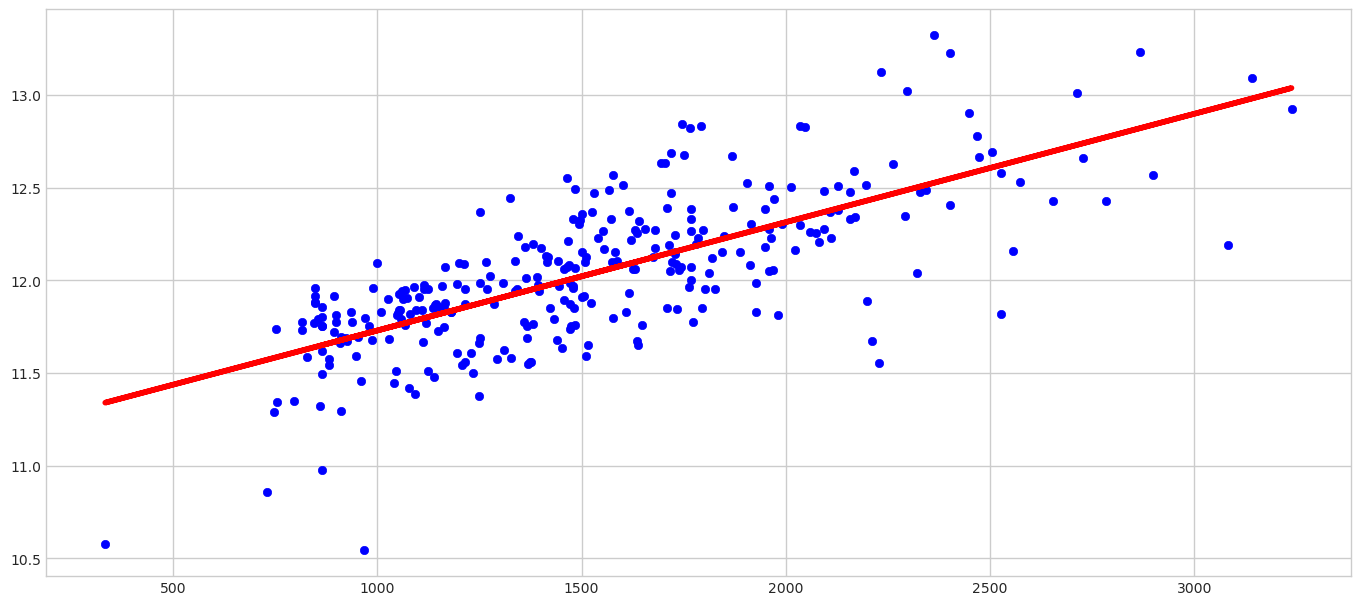

In [67]:
# create a figure
fig = plt.figure(figsize=(15,7))
# get the axis of that figure
ax = plt.gca()

# plot a scatter plot on it with our data
ax.scatter(sample_train.GrLivArea, sample_train.SalePrice, c='b')
ax.plot(sample_train['GrLivArea'], sample_train['Linear_Yhat'], color='r');

In [68]:
## getting mse
print("Mean Squared Error(MSE) for regression line is : {}".format(np.square(sample_train['SalePrice'] - sample_train['Linear_Yhat']).mean()))

Mean Squared Error(MSE) for regression line is : 0.07722167186468187


In [69]:
from sklearn.metrics import mean_squared_error
mean_squared_error(sample_train['SalePrice'], sample_train.Linear_Yhat)

0.07722167186468183

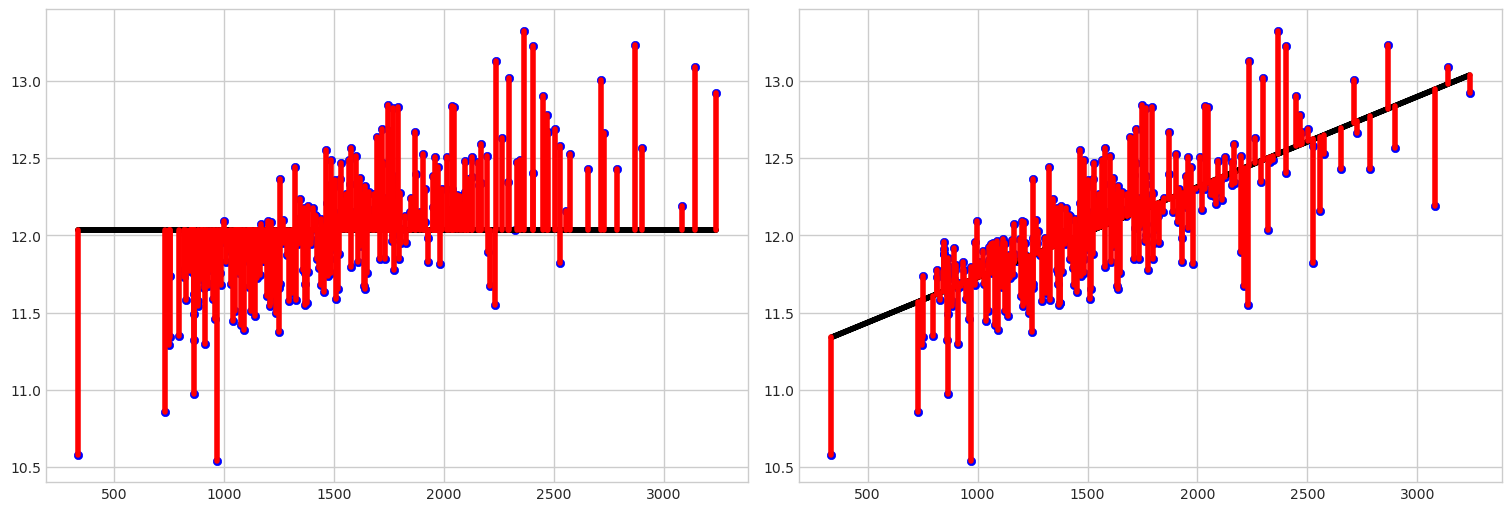

In [70]:
## Creating a customized chart. and giving in figsize and everything. 
fig = plt.figure(constrained_layout=True, figsize=(15,5))
## creating a grid of 3 cols and 3 rows. 
grid = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
#gs = fig3.add_gridspec(3, 3)
#ax1 = fig.add_subplot(grid[row, column])
ax1 = fig.add_subplot(grid[0, :1])

# get the axis
ax1 = fig.gca()

# plot it
ax1.scatter(x=sample_train['GrLivArea'], y=sample_train['SalePrice'], c='b')
ax1.plot(sample_train['GrLivArea'], sample_train['mean_sale_price'], color='k');

# iterate over predictions
for _, row in sample_train.iterrows():
    plt.plot((row['GrLivArea'], row['GrLivArea']), (row['SalePrice'], row['mean_sale_price']), 'r-')
    
ax2 = fig.add_subplot(grid[0, 1:])

# plot it
ax2.scatter(x=sample_train['GrLivArea'], y=sample_train['SalePrice'], c='b')
ax2.plot(sample_train['GrLivArea'], sample_train['Linear_Yhat'], color='k');
# iterate over predictions
for _, row in sample_train.iterrows():
    plt.plot((row['GrLivArea'], row['GrLivArea']), (row['SalePrice'], row['Linear_Yhat']), 'r-')

In [71]:
## importing necessary models.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Call in the LinearRegression object
lin_reg = LinearRegression(normalize=True, n_jobs=-1)
## fit train and test data. 
lin_reg.fit(X_train, y_train)
## Predict test data. 
y_pred = lin_reg.predict(X_test)

In [72]:
## get average squared error(MSE) by comparing predicted values with real values. 
print ('%.2f'%mean_squared_error(y_test, y_pred))

15992356279383781376.00


# Using CV

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
lin_reg = LinearRegression()
cv = KFold(shuffle=True, random_state=2, n_splits=10)
scores = cross_val_score(lin_reg, X,y,cv = cv, scoring = 'neg_mean_absolute_error')

In [74]:
print ('%.8f'%scores.mean())

-0.23307150


Ridge

In [75]:
## Importing Ridge. 
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
## Assiging different sets of alpha values to explore which can be the best fit for the model. 
alpha_ridge = [-3,-2,-1,1e-15, 1e-10, 1e-8,1e-5,1e-4, 1e-3,1e-2,0.5,1,1.5, 2,3,4, 5, 10, 20, 30, 40]
temp_rss = {}
temp_mse = {}
for i in alpha_ridge:
    ## Assigin each model. 
    ridge = Ridge(alpha= i, normalize=True)
    ## fit the model. 
    ridge.fit(X_train, y_train)
    ## Predicting the target value based on "Test_x"
    y_pred = ridge.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rss = sum((y_pred-y_test)**2)
    temp_mse[i] = mse
    temp_rss[i] = rss

In [76]:
for key, value in sorted(temp_mse.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

0.01: 0.012058094344108686
0.001: 0.01236180658288817
0.5: 0.012398339913726674
0.0001: 0.012454841268914387
1e-05: 0.012608710717880963
1e-08: 0.012689390205083658
1e-15: 0.01268939877977284
1e-10: 0.012689501729278522
1: 0.013828461488303467
1.5: 0.015292912711229756
2: 0.016759826520931755
3: 0.019679216398439565
4: 0.022565155602491668
5: 0.025406035094896008
10: 0.0386975007515975
20: 0.060169516596010005
30: 0.07597213328310044
40: 0.08783870516856798
-1: 22.58422790736848
-3: 37.77842184405893
-2: 1127.9927997424456


In [77]:
for key, value in sorted(temp_rss.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

0.01: 5.787885285172173
0.001: 5.93366715978632
0.5: 5.951203158588801
0.0001: 5.978323809078905
1e-05: 6.052181144582858
1e-08: 6.090907298440156
1e-15: 6.090911414290963
1e-10: 6.090960830053685
1: 6.637661514385663
1.5: 7.34059810139028
2: 8.044716730047242
3: 9.446023871250993
4: 10.831274689196
5: 12.194896845550092
10: 18.574800360766798
20: 28.881367966084785
30: 36.46662397588824
40: 42.16257848091258
-1: 10840.42939553688
-3: 18133.642485148288
-2: 541436.5438763741


Lasso

In [78]:
from sklearn.linear_model import Lasso 
temp_rss = {}
temp_mse = {}
for i in alpha_ridge:
    ## Assigin each model. 
    lasso_reg = Lasso(alpha= i, normalize=True)
    ## fit the model. 
    lasso_reg.fit(X_train, y_train)
    ## Predicting the target value based on "Test_x"
    y_pred = lasso_reg.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rss = sum((y_pred-y_test)**2)
    temp_mse[i] = mse
    temp_rss[i] = rss

In [79]:
for key, value in sorted(temp_mse.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

0.0001: 0.010061310725138255
1e-05: 0.011553827902412753
1e-08: 0.012457467852344159
1e-10: 0.012462691939063401
1e-15: 0.012462746140637337
0.001: 0.018344141585259634
0.01: 0.15998234085337362
0.5: 0.16529633945001213
1: 0.16529633945001213
1.5: 0.16529633945001213
2: 0.16529633945001213
3: 0.16529633945001213
4: 0.16529633945001213
5: 0.16529633945001213
10: 0.16529633945001213
20: 0.16529633945001213
30: 0.16529633945001213
40: 0.16529633945001213
-1: 13593671877.534101
-2: 54374687290.1697
-3: 122343046241.0627


In [80]:
for key, value in sorted(temp_rss.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

0.0001: 4.829429148066364
1e-05: 5.545837393158122
1e-08: 5.979584569125193
1e-10: 5.982092130750429
1e-15: 5.982118147505927
0.001: 8.805187960924625
0.01: 76.79152360961929
0.5: 79.34224293600582
1: 79.34224293600582
1.5: 79.34224293600582
2: 79.34224293600582
3: 79.34224293600582
4: 79.34224293600582
5: 79.34224293600582
10: 79.34224293600582
20: 79.34224293600582
30: 79.34224293600582
40: 79.34224293600582
-1: 6524962501216.369
-2: 26099849899281.46
-3: 58724662195710.13


ElasticNet

In [81]:
from sklearn.linear_model import ElasticNet
temp_rss = {}
temp_mse = {}
for i in alpha_ridge:
    ## Assigin each model. 
    lasso_reg = ElasticNet(alpha= i, normalize=True)
    ## fit the model. 
    lasso_reg.fit(X_train, y_train)
    ## Predicting the target value based on "Test_x"
    y_pred = lasso_reg.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rss = sum((y_pred-y_test)**2)
    temp_mse[i] = mse
    temp_rss[i] = rss

In [82]:
for key, value in sorted(temp_mse.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

0.0001: 0.010410659762974166
1e-05: 0.01178633880455573
1e-08: 0.012459291800783737
1e-10: 0.012462710318946567
1e-15: 0.012462746140821301
0.001: 0.01497089650380901
0.01: 0.10870286541991268
0.5: 0.16529633945001213
1: 0.16529633945001213
1.5: 0.16529633945001213
2: 0.16529633945001213
3: 0.16529633945001213
4: 0.16529633945001213
5: 0.16529633945001213
10: 0.16529633945001213
20: 0.16529633945001213
30: 0.16529633945001213
40: 0.16529633945001213
-3: 5.388825749144781
-2: 5.470945132445548
-1: 5.729175728283697


In [83]:
for key, value in sorted(temp_rss.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

0.0001: 4.997116686227604
1e-05: 5.657442626186748
1e-08: 5.980460064376199
1e-10: 5.982100953094351
1e-15: 5.982118147594226
0.001: 7.186030321828328
0.01: 52.177375401558095
0.5: 79.34224293600582
1: 79.34224293600582
1.5: 79.34224293600582
2: 79.34224293600582
3: 79.34224293600582
4: 79.34224293600582
5: 79.34224293600582
10: 79.34224293600582
20: 79.34224293600582
30: 79.34224293600582
40: 79.34224293600582
-3: 2586.636359589493
-2: 2626.0536635738636
-1: 2750.0043495761765


# Fitting Model (Advanced Approach)

In [84]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [85]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [86]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, 
                                              alphas=alphas2, 
                                              random_state=42, 
                                              cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [87]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, 
                                max_depth=4, max_features='sqrt', 
                                min_samples_leaf=15, min_samples_split=10, 
                                loss='huber', random_state =42)

In [88]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [89]:
# xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
#                                      max_depth=3, min_child_weight=0,
#                                      gamma=0, subsample=0.7,
#                                      colsample_bytree=0.7,
#                                      objective='reg:linear', nthread=-1,
#                                      scale_pos_weight=1, seed=27,
#                                      reg_alpha=0.00006)

In [90]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, lightgbm),
                                meta_regressor=lasso,
                                use_features_in_secondary=True)

In [91]:
score = cv_rmse(ridge)
print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(gbr)
# print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(xgboost)
# print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

Ridge: 0.1011 (0.0141)
 2022-12-20 18:13:34.339456
LASSO: 0.0997 (0.0142)
 2022-12-20 18:13:40.514971
elastic net: 0.0998 (0.0143)
 2022-12-20 18:14:25.787154
SVR: 0.1020 (0.0146)
 2022-12-20 18:14:32.985182
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Cu

In [92]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge') 
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

# print('GradientBoosting')
# gbr_model_full_data = gbr.fit(X, y)

# print('xgboost')
# xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
stack_gen
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0

# Blending Models

In [93]:
1.0 * elastic_model_full_data.predict(X)

array([12.22535069, 12.19481394, 12.28746198, ..., 12.45059162,
       11.84620006, 11.91614323])

In [94]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.2 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
#             (0.1 * gbr_model_full_data.predict(X)) + \
#            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

In [95]:
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
1.8060682234138357


In [96]:
print('Predict submission')
submission = pd.read_csv("sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))

Predict submission


In [97]:
submission

,Id,SalePrice
0,1461,21017.0
1,1462,26230.0
2,1463,30298.0
3,1464,32296.0
4,1465,30888.0
...,...,...
1454,2915,15751.0
1455,2916,14961.0
1456,2917,27972.0
1457,2918,20355.0


In [98]:
q1 = submission['SalePrice'].quantile(0.005)
q2 = submission['SalePrice'].quantile(0.995)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

In [99]:
submission

,Id,SalePrice
0,1461,21017.0
1,1462,26230.0
2,1463,30298.0
3,1464,32296.0
4,1465,30888.0
...,...,...
1454,2915,15751.0
1455,2916,14961.0
1456,2917,27972.0
1457,2918,20355.0


In [100]:
submission.to_csv("submission.csv", index=False)